# Importing the required packages

In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyomo.environ as pyo
from pyomo.dae import ContinuousSet, DerivativeVar, Simulator
from pyomo.opt import SolverFactory
from pyomo.contrib.parmest import parmest # import parmest
from pyomo.contrib.parmest.experiment import Experiment
from pyomo.contrib.doe import DesignOfExperiments
import idaes.core.solvers.get_solver   # import the idaes solvers

# Data

Table S1. Initial guesses for the kinetic parameter values used to test the sensitivity of MBDoE to the initial parameter
estimates (both Ramp F and Ramp FT scenarios).

## Parameter: initial guess

In [2]:
# theta_init = {
#     "Parameter Set": ["Factorial Estimates", "A", "B", "C", "D"],
#     "KP1": [9.12, 8.5, 9.5, 8.5, 9.5],
#     "KP2": [7.98, 6.0, 11, 10, 7.0],
#     "k0 (s^-1)": ["1.17E+07", "3.95E+04", "1.17E+11", "1.32E+10", "3.49E+05"],
#     "EA (J/mol)": [79800, 60000, 110000, 100000, 70000],
#     "k at 100°C (*10^5 s^-1)": [0.78, 1.58, 0.47, 1.33, 0.56],
#     "k at 120°C (*10^5 s^-1)": [2.88, 4.21, 2.84, 6.85, 1.75],
#     "k at 140°C (*10^5 s^-1)": [9.40, 10.25, 14.50, 30.11, 4.94]
# }

# theta_init = pd.DataFrame(theta_init)
# theta_init.columns = ['Parameter Set', 'KP1', 'KP2', 'k0', 'EA',
#        'k@100C', 'k@120C', 'k@140C']
# theta_init


## Flowrate ramp at 119°C and $C_F$ = 1.56M

Table S2. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the first MBDoE Ramp
F experiment. The initial flowrate was 29.8 µL/min, the flowrate was ramped down at a rate of 0.253 µL/min2
, while the temperature was held constant at 119°C and the feed concentration was 1.56 M.

In [3]:
data_FR1 = {
    "tM,i Time the sample was measured (s)": [408, 828, 1248, 1667, 2084, 2504, 2923, 3342, 3763, 4182, 4603, 5024, 5444, 5864],
    "tIn,i Time the sample entered the reactor (s)": [110, 511, 910, 1304, 1693, 2080, 2460, 2833, 3198, 3549, 3885, 4199, 4481, 4722],
    "tL,i Time the sample left the reactor (s)": [314, 728, 1141, 1552, 1959, 2368, 2774, 3177, 3578, 3972, 4360, 4736, 5094, 5422],
    "τi Sample reaction time (s)": [204, 217, 231, 248, 267, 288, 314, 344, 380, 422, 474, 537, 613, 700],
    "X Conversion (%)": [5.8, 5.8, 6.4, 7.1, 7.1, 7.7, 8.3, 9.0, 9.6, 10.9, 12.2, 13.5, 14.7, 16.7],
    "Outlet Concentration Benzoic Acid (M)": [1.47, 1.47, 1.46, 1.45, 1.45, 1.44, 1.43, 1.42, 1.41, 1.39, 1.37, 1.35, 1.33, 1.30],
    "Outlet Concentration Ethyl Benzoate (M)": [0.09, 0.09, 0.10, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.18, 0.20, 0.23, 0.25]
}

ramp_F1 = pd.DataFrame(data_FR1)
ramp_F1.columns = columns=["t_m(s)", "t_in(s)", "t_L(s)", "tau(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# adding the temperature to the data
ramp_F1["T(C)"] = 119
# adding the feed concentration to the data
ramp_F1["C_F(M)"] = 1.56

# adding the ramped flowrate to the data
initial_flowrate = 29.8  # µL/min
ramp_rate = 0.253  # µL/min^2

# Calculate the time elapsed since the start of the ramp
time_elapsed = ramp_F1['t_in(s)']

# Calculate the flowrate at each time point
ramp_F1['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
ramp_F1

,t_m(s),t_in(s),t_L(s),tau(s),X(%),C_BA(M),C_EB(M),T(C),C_F(M),F(µL/min)
0,408,110,314,204,5.8,1.47,0.09,119,1.56,29.336167
1,828,511,728,217,5.8,1.47,0.09,119,1.56,27.645283
2,1248,910,1141,231,6.4,1.46,0.10,119,1.56,25.962833
3,1667,1304,1552,248,7.1,1.45,0.10,119,1.56,24.301467
4,2084,1693,1959,267,7.1,1.45,0.11,119,1.56,22.661183
5,2504,2080,2368,288,7.7,1.44,0.12,119,1.56,21.029333
6,2923,2460,2774,314,8.3,1.43,0.13,119,1.56,19.427000
7,3342,2833,3177,344,9.0,1.42,0.14,119,1.56,17.854183
8,3763,3198,3578,380,9.6,1.41,0.15,119,1.56,16.315100
9,4182,3549,3972,422,10.9,1.39,0.17,119,1.56,14.835050


In [4]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_F1["t_m(s)"], ramp_F1["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_F1["t_m(s)"], ramp_F1["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_F1["t_m(s)"], ramp_F1["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_F1["t_m(s)"], ramp_F1["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_F1["t_m(s)"], ramp_F1["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 119°C and 1.56 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

## Flowrate ramp at 139.4C and $C_F$ = 1.55 M

Table S3. Time each sample was measured, left and entered the reactor and corresponding reaction time,
along with conversion and outlet concentrations of benzoic acid and ethyl benzoate for the second MBDoE
Ramp F experiment. The initial flowrate was 9.13 µL/min, the flowrate was ramped down at a rate of 0.043
µL/min2, while the temperature was held constant at 139.4 oC and the feed concentration was 1.55 M.  

In [5]:
data_FR2 = {
    "Time the sample was measured (t_M,i)": [152, 571, 991, 1411, 1830, 2251, 2670, 3090, 3510, 3931, 4350, 4770, 5190, 5610],
    "Time the sample entered the reactor (t_In,i)": [None, None, 17, 404, 787, 1170, 1549, 1925, 2298, 2668, 3033, 3393, 3749, 4098],
    "Time the sample left the reactor (t_L,i)": [None, 271, 680, 1089, 1496, 1904, 2309, 2714, 3117, 3520, 3920, 4318, 4715, 5109],
    "Sample reaction time (τ_i)": [623, 643, 663, 685, 709, 734, 760, 789, 819, 852, 887, 925, 966, 1010],
    "Conversion (X)": [44.9, 45.5, 46.2, 47.4, 48.1, 48.7, 50.0, 51.3, 51.9, 53.8, 55.1, 56.4, 57.7, 59.0],
    "Outlet Concentration Benzoic Acid (M)": [0.86, 0.85, 0.84, 0.82, 0.81, 0.80, 0.78, 0.76, 0.75, 0.72, 0.70, 0.68, 0.66, 0.64],
    "Outlet Concentration Ethyl Benzoate (M)": [0.70, 0.70, 0.72, 0.73, 0.74, 0.76, 0.78, 0.79, 0.81, 0.83, 0.86, 0.87, 0.90, 0.92]
}

ramp_F2 = pd.DataFrame(data_FR2)
ramp_F2.columns = columns=["t_m(s)", "t_in(s)", "t_L(s)", "tau(s)", "X(%)", "C_BA(M)", "C_EB(M)"]
# adding the temperature to the data
ramp_F2["T(C)"] = 139.4 #oC
# adding the feed concentration to the data
ramp_F2["C_F(M)"] = 1.55  # M

# adding the ramped flowrate to the data
initial_flowrate = 9.13  # µL/min
ramp_rate = 0.043  # µL/min

# Calculate the time elapsed since the start of the ramp
time_elapsed = ramp_F2['t_m(s)']

# Calculate the flowrate at each time point
ramp_F2['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)
ramp_F2 = ramp_F2.dropna(ignore_index=True)  # our data contains NaN values, we are dropping them
ramp_F2


,t_m(s),t_in(s),t_L(s),tau(s),X(%),C_BA(M),C_EB(M),T(C),C_F(M),F(µL/min)
0,991,17.0,680.0,663,46.2,0.84,0.72,139.4,1.55,8.419783
1,1411,404.0,1089.0,685,47.4,0.82,0.73,139.4,1.55,8.118783
2,1830,787.0,1496.0,709,48.1,0.81,0.74,139.4,1.55,7.818500
3,2251,1170.0,1904.0,734,48.7,0.80,0.76,139.4,1.55,7.516783
4,2670,1549.0,2309.0,760,50.0,0.78,0.78,139.4,1.55,7.216500
5,3090,1925.0,2714.0,789,51.3,0.76,0.79,139.4,1.55,6.915500
6,3510,2298.0,3117.0,819,51.9,0.75,0.81,139.4,1.55,6.614500
7,3931,2668.0,3520.0,852,53.8,0.72,0.83,139.4,1.55,6.312783
8,4350,3033.0,3920.0,887,55.1,0.70,0.86,139.4,1.55,6.012500
9,4770,3393.0,4318.0,925,56.4,0.68,0.87,139.4,1.55,5.711500


In [6]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_F2["t_m(s)"], ramp_F2["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_F2["t_m(s)"], ramp_F2["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_F2["t_m(s)"], ramp_F2["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_F2["t_m(s)"], ramp_F2["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_F2["t_m(s)"], ramp_F2["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 139.4°C and 1.55 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

## Flowrate and Temperature ramp

Table S4. Time each sample was measured, left and entered the reactor, corresponding reaction time, and the
reactor temperature at the time the samples entered and left the reactor, along with conversion and outlet
concentrations of benzoic acid and ethyl benzoate for the MBDoE Ramp FT experiment. The initial flowrate
was 10.1 µL/min, the flowrate was ramped down at a rate of 0.05 µL/min2
, while the initial temperature was
139.2 °C, and it was ramped down at a rate of 0.537 °C/min. The feed concentration of benzoic acid was held
constant at 1.56 M. 
  
This data has some issues. We can see that `t_L` is less than `tau`, which shouldn't be the case. In the model, we will set `t_L` = `t_in` + `tau` as a measure to address this issue.

In [7]:
data_FT = {
    "Time the sample was measured (s)": [419, 840, 1260, 1679, 2099, 2519, 2939, 3359, 3779, 4199, 4619, 5038, 5457, 5876],
    "Time the sample entered the reactor (s)": [np.nan, np.nan, 354, 739, 1124, 1505, 1883, 2258, 2629, 2996, 3358, 3714, 4064, 4407],
    "Time the sample left the reactor (s)": [np.nan, 150, 561, 971, 1379, 1786, 2193, 2599, 3003, 3406, 3807, 4206, 4602, 4995],
    "Sample reaction time (s)": [577, 596, 617, 639, 663, 688, 716, 745, 777, 811, 848, 888, 931, 979],
    "Reactor temperature at time tini (°C)": [139.2, 139.2, 136.0, 132.6, 129.1, 125.7, 122.3, 119.0, 115.7, 112.4, 109.1, 106.0, 102.8, 99.8],
    "Reactor temperature at time tLi (°C)": [139.2, 134.2, 130.5, 126.9, 123.2, 119.6, 115.9, 112.3, 108.7, 105.1, 101.6, 98.0, 94.5, 91.0],
    "X Conversion (%)": [41.5, 39.6, 35.1, 31.2, 26.7, 23.5, 19.7, 17.1, 14.5, 12.6, 10.0, 8.7, 7.5, 6.2],
    "Outlet Conc. Benzoic Acid (M)": [0.91, 0.94, 1.01, 1.07, 1.14, 1.19, 1.25, 1.29, 1.33, 1.36, 1.40, 1.42, 1.44, 1.46],
    "Outlet Conc. Ethyl Benzoate (M)": [0.64, 0.62, 0.55, 0.49, 0.42, 0.37, 0.31, 0.27, 0.22, 0.19, 0.16, 0.13, 0.11, 0.09]
}

ramp_FT = pd.DataFrame(data_FT)
ramp_FT.columns = columns=["t_m(s)", "t_in(s)", "t_L(s)", "tau(s)", "T_in(C)", "T_L(C)", "X(%)", "C_BA(M)", "C_EB(M)"]

# adding the temperature to the data
T_ramp_rate = 0.537 # °C/min
time_elapsed = ramp_FT['t_in(s)']

# adding the feed concentration to the data
ramp_FT["C_F(M)"] = 1.56  # M

# adding the ramped flowrate to the data
initial_flowrate = 10.1  # µL/min
ramp_rate = 0.05 # µL/min^2

ramp_FT = ramp_FT.dropna(ignore_index=True)

# # Calculate the flowrate at each time point
# ramp_FT['F(µL/min)'] = initial_flowrate - (ramp_rate * time_elapsed / 60)

ramp_FT

,t_m(s),t_in(s),t_L(s),tau(s),T_in(C),T_L(C),X(%),C_BA(M),C_EB(M),C_F(M)
0,1260,354.0,561.0,617,136.0,130.5,35.1,1.01,0.55,1.56
1,1679,739.0,971.0,639,132.6,126.9,31.2,1.07,0.49,1.56
2,2099,1124.0,1379.0,663,129.1,123.2,26.7,1.14,0.42,1.56
3,2519,1505.0,1786.0,688,125.7,119.6,23.5,1.19,0.37,1.56
4,2939,1883.0,2193.0,716,122.3,115.9,19.7,1.25,0.31,1.56
5,3359,2258.0,2599.0,745,119.0,112.3,17.1,1.29,0.27,1.56
6,3779,2629.0,3003.0,777,115.7,108.7,14.5,1.33,0.22,1.56
7,4199,2996.0,3406.0,811,112.4,105.1,12.6,1.36,0.19,1.56
8,4619,3358.0,3807.0,848,109.1,101.6,10.0,1.40,0.16,1.56
9,5038,3714.0,4206.0,888,106.0,98.0,8.7,1.42,0.13,1.56


In [8]:
# # Plotting the data
# fig, ax = plt.subplots(figsize=(10, 6))
# # plotting on left y-axis
# ax.plot(ramp_FT["t_m(s)"], ramp_FT["T(C)"], "-k", label="Temperature($^oC$)")
# ax.plot(ramp_FT["t_m(s)"], ramp_FT["F(µL/min)"], "-.c", label="Flowrate(µL/min)")
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Temperature (°C), Flowrate (µL/min)')
# ax.tick_params('y', colors='k')
# ax.set_ylim(0, 160)

# # plotting on right y-axis
# ax2 = ax.twinx()
# ax2.plot(ramp_FT["t_m(s)"], ramp_FT["C_F(M)"], "^r", label="Feed Concentration(M)")
# ax2.plot(ramp_FT["t_m(s)"], ramp_FT["C_BA(M)"], "og", label=r"$C_{BA}$(M)")
# ax2.plot(ramp_FT["t_m(s)"], ramp_FT["C_EB(M)"], "sb", label=r"$C_{EB}$(M)")
# ax2.set_ylabel('Concentration (M)')
# ax2.tick_params('y', colors='k')
# ax2.set_ylim(0, 1.6)

# # Customize the plot
# plt.title('Flowrate ramp at 139.4°C and 1.55 M feed concentration')
# fig.tight_layout()

# # Combine legends from both axes
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2)

# Model

**Reaction:** 
            $$\text{Benzoid Acid + Ethanol = Ethyl Benzoate + Water}$$

**Reactor and feed parameters:**  
$\qquad d, \: \text{reactor diameter = } 250\times 10^{-5} dm\\$
$\qquad l, \: \text{length of the reactor = } 20 \, dm \\$
$\qquad \nu $, volumetric flow rate, $L/min\\$
$\qquad \nu_0 \text{, initial volumetric flow rate = } 29.8\times 10 ^{-6} L/min\\$
$\qquad C_{BA}  \text{ concentration of benzoic acid,} 1.56 M\\$
$\qquad \alpha_v \text{, volumetric ramp rate = }-0.253\times 10 ^{-6} L/min^2$  
$\qquad z \rightarrow$ distance from the entrance of the reactor, $ dm$


**1. Model**  
Material Balance for a transient Plug Flow Reactor (PFR):


\begin{equation}
\frac{\partial C_{BA}}{\partial t} = - \nu (t) \frac{\partial C_{BA}}{\partial V} + r_{BA} \tag{1}
\end{equation}


Substituting $V = A_C z$ and $r_{BA} = - k C_{BA}$ into equation (1):


\begin{equation}
\frac{\partial C_{BA}}{\partial t} = - \frac{\nu(t)}{A_c} \frac{\partial C_{BA}}{\partial z} - k C_{BA} \tag{2}
\end{equation}


The expression for the reaction rate constant, $k$, is given by:


\begin{equation}
k = \exp \left(-KP1 - \frac{KP2 \times 10000}{R} \times \left[ \frac{1}{T} - \frac{1}{T_M}\right]\right) \tag{3}
\end{equation}


The expression for the ramped flow rate, $\nu(t)$, is:


\begin{equation}
\nu(t) = \nu_0 - \alpha_\nu t \tag{4}
\end{equation}


**Parameters to estimate:** $KP1, KP2\\$
**Design variables:** $\nu_0, C_{BA0}, T_0, \alpha_\nu, \alpha_T$

**2. Boundary and initial conditions**  
Boundary Condition at the Reactor Inlet (z=0)
$$
C_{BA}(t ≥ t_0, z = 0) = C_{BA0}  \tag{5}
$$
where, $t_0$ is the time at which the reactant reaches the reactor inlet.

Initially there was no benzoic acid in the PFR.  
$$
C_{BA}(t = 0, z) = 0  \tag{6}
$$




## Space time and feed velocity

In [9]:
# area = np.pi * (250e-5 /2)**2  # dm^2
# length = 20 # dm
# Volume = area * length  # L
# volumetric_flowrate = 29.8e-6  # L/min
# space_time = Volume / volumetric_flowrate  # min
# velocity = volumetric_flowrate / (area * 10 * 60) # dm/s
# print("space time: {a: 0.3f} min".format(a=space_time))
# print("velocity: %0.4f dm/s" %velocity)

# Simulating the Reactor with literature parameter data
## Steady-State PFR

In [10]:
# # Simulating steady state model
# nfe =50 # number of finite elements
# # SIMULATING THE MODEL USING IPOPT
# def BA_kinetics_ss():
#     m = pyo.ConcreteModel()

#     # Conversion factors
#     m.SEC2MIN = 1 / 60  # seconds to minutes
    
#     # Define sets
#     m.t = ContinuousSet(bounds=(0, 3.294455383378558))  # reaction time in minutes, upper bound = spce_time

#     # Define variables
#     m.C_BA = pyo.Var(m.t, initialize=1.56)  # benzoic acid concentration in M

#     # Define derivative variables
#     m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)

#     # Define parameters
#     m.k =  pyo.Param(initialize = (10e-5 / m.SEC2MIN))  # reaction rate constant, min^-1


#     # TODO: replace these hyperparameters with `initial_values` in the `__init__` constructor
#     # hyperparameters       
#     m.C_BA0 = pyo.Param(initialize=1.56)  # initial benzoic acid concentration, M

               
#     # Define the differential equations
#     @m.Constraint(m.t)
#     def _ideal_pfr_eqn(m, t):
#         # if t == 0:
#         #     return pyo.Constraint.Skip
#         # else:
#         return (
#                 m.dC_BA_dt[t] == - m.k * m.C_BA[t]
#             )  # PDE of the concentration of BA

      
#     # Boundary and initial conditions
#     # m.C_BA[0].fix(m.C_BA0) 
#     @m.Constraint()
#     def _inlet_conc(m):
#         return m.C_BA[0] == m.C_BA0


#     # Discretize the model using finite difference
#     pyo.TransformationFactory("dae.finite_difference").apply_to(m, nfe=nfe, scheme="FORWARD", wrt=m.t)  # discretize wrt time

#     # Let's define initial conditions for z>0
#     # for z in m.z:
#     #     if z > 0:
#     #         m.C_BA[0, z].fix(0)
        
    
#     # m.pprint()
#     # Solve the model
   
#     solver = SolverFactory("ipopt")
#     solver.options["linear_solver"] = "MA57"
#     solver.options["max_iter"] = 100
#     res = solver.solve(m, tee=False)

#     return res, m  # return the results and the model

# result, model = BA_kinetics_ss()

# # Extract results
# t_vals = list(model.t)
# C_BA_vals = [model.C_BA[t]() for t in t_vals]

# # Plot the concentration profile
# plt.plot(t_vals, C_BA_vals, label='C_BA(t)')
# plt.xlabel('time')
# plt.ylabel('Concentration (M)')
# plt.title('PFR Concentration Profile')
# plt.legend()
# plt.grid()
# plt.show()

## Transient PFR

In [11]:
# # SIMULATING THE MODEL USING IPOPT
# def BA_kinetics(
#     discr_method="dae.collocation", scheme="LAGRANGE-RADAU", nfe_t=20, nfe_z=20, ncp=3
# ):
#     m = pyo.ConcreteModel()

#     # Conversion factors
#     m.SEC2MIN = 1 / 60  # seconds to minutes
#     m.R = 8.314  # universal gas constant, J/mol/K
#     m.TM = 378.15
#     m.T = 119 + 273.15  # temperature of the reactor, K

#     # Define sets
#     m.Length = 20
#     m.t = ContinuousSet(bounds=(0, 4))  # reaction time in minutes, upper bound = spce_time
#     m.z = ContinuousSet(bounds=(0, m.Length))
#     # m.t = ContinuousSet(bounds=(0, 4))  # reaction time in minutes, upper bound = spce_time
#     # m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor: 20 dm

#     # Define variables
#     m.C_BA = pyo.Var(m.t, m.z, initialize=1e-8, bounds=(0, 1.56))  # benzoic acid concentration in M

#     # Define derivative variables
#     m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
#     m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

#     # Define parameters
#     # initial guess from the paper
#     # m.KP1 = 9.12
#     # m.KP2 = 7.98
#     # Optimized from our pfr model
#     m.KP1 = 8.69646  # dimensionless
#     m.KP2 = 4.10409  # J/mol
#     m.k0 = pyo.Expression(expr= pyo.exp(-m.KP1 + m.KP2 * 10000 / (m.R * m.TM)))
#     # equation for activation energy, EA
#     m.EA = pyo.Expression(expr= m.KP2 * 10000)
#     # equation for the Arrhenius equation
#     m.k = pyo.Expression(expr= pyo.exp(-m.KP1 - (m.KP2 * 10000 / m.R) * (1 / m.T - 1 / m.TM)) / m.SEC2MIN)

#     # hyperparameters
#     m.alpha_v = pyo.Param(initialize= - 0.253e-6) # flowrate ramp, L/min^2
#     m.v0 = pyo.Var(initialize=29.8e-6)  # initial flowrate, L/min    
#     m.v = pyo.Var(m.t, initialize=29.8e-6)  # flowrate, L
#     m.C_BA0 = pyo.Param(initialize=1.56)  # initial benzoic acid concentration, M

#     # Constants
#     m.d = 250e-5  # diameter of the reactor, dm (decimeters)
#     m.Ac = np.pi * (m.d / 2) ** 2  # Reactor cross-sectional area, dm^2

#     # Define the differential equations
#     @m.Constraint(m.t, m.z)
#     def _pde_eqn(m, t, z):
#         if z == 0:
#             return pyo.Constraint.Skip   # we skip the PDE at z=0, b/c at z=0 the feed just entered and the conc does not change with time
#         else:
#             return (
#                     m.dC_BA_dt[t, z] == - (m.v[t] / m.Ac) * m.dC_BA_dz[t, z] - m.k * m.C_BA[t, z]
#                 )  # PDE of the concentration of BA

#         # ramping the flowrate
#     @m.Constraint(m.t)
#     def flowrate_ramp(m, t):
#         return m.v[t] == m.v0 - m.alpha_v * t # L/min. 
#         # Note: only `self.t_in` is converted to min, b/c `m.t` is already in min.

#     # @m.Constraint(m.t, m.z)
#     # def _pde_eqn(m, t, z):
#     #     return (
#     #             m.dC_BA_dt[t, z] == - (m.v0 / m.Ac) * m.dC_BA_dz[t, z] - m.k * m.C_BA[t, z]
#     #         )  # PDE of the concentration of BA

#     # Boundary conditions
#     @m.Constraint(m.t)
#     def _inlet_conc(m, t):
#         return m.C_BA[t, 0] == m.C_BA0

#     # @m.Constraint(m.t)
#     # def _der_at_z20(m, t):
#     #     return m.dC_BA_dz[t, 20] == 0

#     # Discretize the model using finite difference

#     if discr_method == "dae.finite_difference":
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_t, scheme= scheme, wrt=m.t)  # discretize wrt time
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_z, scheme=scheme, wrt=m.z)  # discretize wrt length

#     elif discr_method == "dae.collocation":
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_t, ncp=ncp, scheme=scheme, wrt=m.t)  # discretize wrt time
#         pyo.TransformationFactory(discr_method).apply_to(m, nfe=nfe_z, ncp=ncp, scheme=scheme, wrt=m.z)  # discretize wrt length

#     # Let's define initial conditions for z>0
#     for z in m.z:
#         if z > 0:
#             m.C_BA[0, z].fix(0) 

#     m.v0.fix(29.8e-6)  # fix the initial flowrate to 29.8 L/min

#     # Initial condition for first derivative wrt z at the PFR inlet
#     # for z in m.z:
#     #    m.dC_BA_dz[0,z].fix(0)

#     '''
#     def obj_C_BA(m):
#         return sum(m.dC_BA_dz[t, z] for t in m.t for z in m.z)

#     m.obj = pyo.Objective(rule=obj_C_BA, sense=pyo.maximize)
#     '''

#     # Solve the model
#     solver = SolverFactory("ipopt")
#     solver.options["linear_solver"] = "ma57"
#     solver.options["max_iter"] = 200
#     res = solver.solve(m, tee=False)

#     return res, m  # return the results and the model


# result, model = BA_kinetics(
#     discr_method="dae.collocation", scheme="LAGRANGE-RADAU", nfe_t=20, nfe_z=20, ncp=3
# )
# # Extract results
# t_vals = list(model.t)
# z_vals = list(model.z)
# C_BA_vals = [model.C_BA[t, model.Length].value for t in t_vals]

# # Plot the concentration for different residence time
# plt.plot(t_vals, C_BA_vals, label=f'C_BA(t) @ z={z_vals[-1]: 0.2f} dm')
# plt.xlabel('Time (min)')
# plt.ylabel('Concentration (M)')
# plt.title('PFR Concentration at different time at the end of the reactor')
# plt.legend()
# plt.grid()
# plt.show()

In [12]:
# model.pprint()
# C_BA_vals = [model.C_BA[t, model.Length]() for t in t_vals]
# C_BA_vals

## 3D plot
This data in the cell below will be used for 3D plot and Heatmap

In [13]:
# # Convert model arrays
# t_vals = np.array(model.t)  # N_t time points
# z_vals = np.array(model.z)  # N_z spatial points

# # Create meshgrid (ensure Cartesian order)
# t_grid, z_grid = np.meshgrid(t_vals, z_vals, indexing="xy")

# # Reshape C_BA_vals to match (4,3)
# C_BA_vals = np.array([[model.C_BA[t, z]() for t in t_vals] for z in z_vals])  

In [14]:
# # Create figure with 3 subplots (side by side)
# fig, axes = plt.subplots(1, 3, figsize=(24, 8), subplot_kw={'projection': '3d'})

# # First 3D plot (default view)
# ax1 = axes[0]
# ax1.plot_surface(t_grid, z_grid, C_BA_vals, cmap='viridis')
# ax1.set_xlabel('Time (min)')
# ax1.set_ylabel('Length of PFR (dm)')
# ax1.set_zlabel('Concentration (M)', labelpad=-1)  # Increased padding
# ax1.view_init(elev=30, azim=45)  # Adjusted view

# # Second 3D plot (alternate view)
# ax2 = axes[1]
# ax2.plot_surface(t_grid, z_grid, C_BA_vals, cmap='viridis')
# ax2.set_xlabel('Time (min)')
# ax2.set_ylabel('Length of PFR (dm)')
# ax2.set_zlabel('Concentration (M)', labelpad=0)  # Increased padding
# ax2.view_init(elev=20, azim=120)  # Different viewing angle

# # Third 3D plot (another alternate view)
# ax3 = axes[2]
# ax3.plot_surface(t_grid, z_grid, C_BA_vals, cmap='viridis')
# ax3.set_xlabel('Time (min)')
# ax3.set_ylabel('Length of PFR (dm)')
# ax3.set_zlabel('Concentration (M)', labelpad=-1)  # Increased padding
# ax3.view_init(elev=60, azim=210)  # set to default

# # Adjust layout to prevent cropping of labels
# fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.9)

# plt.show()

## Heatmap

In [15]:
# fig, ax = plt.subplots(figsize=(8, 6))

# # Create the heatmap
# c = ax.pcolormesh(t_grid, z_grid, C_BA_vals, cmap='viridis', shading='auto')

# # Add colorbar
# fig.colorbar(c, ax=ax, label='Concentration (M)')

# # Labels and title
# ax.set_xlabel('Time (min)')
# ax.set_ylabel('Length of PFR (dm)')
# ax.set_title('Concentration Heatmap')

# plt.show()


# PDE Class
Here, we will define a class for the transient PFR which uses a PDE model.  
Let's calculate the area and the volume of the PFR first.

In [16]:
# Calculating the area of the reactor
D = 250e-5  # dm
A = np.pi*(D/2)**2
Volume = A * 20 
Volume  # L

9.817477042468103e-05

## Actual time
In this section, we will use the actual time data from the Waldron et al. paper to estimate the parameters of the model.

In [9]:
class TransientPFR(Experiment):
    def __init__(
        self,
        data,
        C_BA0,
        v0,
        T0,
        alpha_v,
        alpha_T=0,
        theta_initial=None,
        discr_method="dae.finite_difference",
        scheme="BACKWARD",
        nfe_t=50,
        nfe_z=50,
        ncp=3,
        t_skip=0,
    ):
        """
        Parameters:
            data: data of the experiment. dtype: pandas dataframe.
            C_BA0: initial concentration of benzoic acid, M
            v0: initial flowrate, µL/min
            T0: initial temperature, °C
            alpha_v: flowrate ramping rate, µL/min^2
            alpha_T: temperature ramping rate, °C/min^2
            theta_initial: initial theta value, dimensionless
            discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.finite_difference"
            scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD". default: "BACKWARD"
            nfe_t: number of finite elements for time, integer. default: 50
            nfe_z: number of finite elements for length, integer. default: 50
            ncp: number of collocation points, integer. default: None
            t_skip: time points to skip, integer. default: 1
        """
        self.data = data
        self.C_BA0 = C_BA0
        self.v0 = v0 * 1e-6  # µL/min to L/min
        self.T0 = T0 + 273.15  # °C to K
        self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
        self.alpha_T = alpha_T
        self.discr_method = discr_method
        self.scheme = scheme
        self.nfe_t = nfe_t
        self.nfe_z = nfe_z
        self.ncp = ncp
        self.model = None
        self.t_skip = t_skip

        # Constants
        self.AREA = 4.908738521234052e-06  # dm^2
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.t_in = self.data.loc[0, "t_in(s)"] * self.SEC2MIN  # min, the time point the sample entered the PFR
        if self.alpha_T != 0:  # Note: This is used b/c the t_L data for FT case is weird.
            self.t_control = (
                self.data.loc[self.t_skip :, "t_in(s)"] 
                + self.data.loc[self.t_skip :, "tau(s)"]
            ) * self.SEC2MIN  # min, the time points the sample left the PFR
        else:        
            self.t_control = (self.data.loc[self.t_skip:, "t_L(s)"]) * self.SEC2MIN  # min, the time points the sample left the PFR

        """
        we will ignore the first time point when the sample lefts the PFR. the PFR was initially empty, we should get a 
        sharp discontinuous jump in concentration when C_BA goes from zero to some value. However, when solving pde, 
        we won't get that sharp jump, it will be a smooth curve.For a sharp curve we need a step size of 0, or 
        nfe= infinity. So, we will ignore the first time point, b/c the first point concentration will be much 
        less than the actual conentration.  For the rest of the time points, we won't have this discontinuous
        jump and the concentration change will be smooth.
        """
        self.t_upper = (
            self.t_control.max()
        )  # min, upper bound of the ContinuousSet time

        if theta_initial is None:
            theta_initial = {"KP1": 9.12, "KP2": 7.98}
        self.theta_initial = theta_initial

    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model

    # ============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel("Transient PFR model")

        # continuous set
        m.t = ContinuousSet(bounds=(0, self.t_upper), initialize=self.t_control)  # min
        m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm
        # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

        # Declare variables
        # Concentration of benzoic acid and ethyl benzene
        m.C_BA0 = pyo.Var(bounds=(0.9, 1.56), initialize=self.C_BA0)  # initial benzoic acid concentration, M
        m.C_BA = pyo.Var(
            m.t, m.z, initialize=self.C_BA0
        )  # benzoic acid concentration in M
        m.C_EB = pyo.Var(m.t, m.z, initialize=0)  # ethyl benzene concentration in M

        # Declare Temperature, K
        m.T0 = pyo.Var(
            bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0
        )  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
        m.alpha_T = pyo.Var(bounds=(0,3), initialize=self.alpha_T)  # temperature ramping rate, K/min^2
        
        # Declare flowrate, L/min
        m.v0 = pyo.Var(
            bounds=(7.5e-6, 100e-6), initialize=self.v0
        )  # initial flowrate in L/min
        m.v = pyo.Var(m.t, initialize=self.v0)  # flowrate in L/min
        m.alpha_v = pyo.Var(bounds=(1e-11, 1.25e-6), initialize=self.alpha_v)  # flowrate ramping rate, L/min^2

        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
        m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds=(0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds=(0, 10))  # J/mol

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(
            expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM))
        )  # sec^(-1)
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr=m.KP2 * 10000)  # J/mol

        # equation for the Arrhenius equation
        @m.Expression(m.t)
        def k(m, t):
            return (
                pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM))
                / self.SEC2MIN
            )  # min^(-1)

        # Define the partial differential equations (PDE)
        @m.Constraint(m.t, m.z)
        def _pde_eqn(m, t, z):
            if z == 0:
                return pyo.Constraint.Skip
            else:
                return (
                    m.dC_BA_dt[t, z]
                    == -(m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z]
                )

        # ramping the flowrate
        @m.Constraint(m.t)
        def flowrate_ramp(m, t):
            return m.v[t] == m.v0 - m.alpha_v * t  # L/min.
            # Note: only `self.t_in` is converted to min, b/c `m.t` is already in min.

        # ramping the temperature
        @m.Constraint(m.t)
        def Temperature_ramp(m, t):
            return m.T[t] == m.T0 - m.alpha_T * t  # K

        @m.Constraint(m.t, m.z)
        def _EB_conc(m, t, z):
            return self.C_BA0 == m.C_BA[t, z] + m.C_EB[t, z]  # M.

    # ============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta_initial["KP1"])
        m.KP2.fix(self.theta_initial["KP2"])

        # Discretizing the model
        if self.discr_method == "dae.finite_difference":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, scheme=self.scheme, wrt=m.t
            )  # discretize wrt time

            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z
            )  # discretize wrt length

        elif self.discr_method == "dae.collocation":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, ncp=self.ncp, scheme=self.scheme, wrt=m.t
            )  # discretize wrt time

            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, ncp=self.ncp, scheme=self.scheme, wrt=m.z
            )  # discretize wrt length

        else:
            raise TypeError(
                "Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'"
            )

        # Let's define initial conditions for z>0
        for z in m.z:
            m.C_BA[0, z].fix(0)  # M

        # Let's define initial conditions for z=0 / fixing the decision variable
        m.C_BA0.fix(self.C_BA0)  # M
        for t in m.t:
            if t >= self.t_in:  # after the feed enters the PFR
                # m.CBA_con = pyo.Constraint(expr=m.C_BA[t, 0] == m.C_BA0)  # M
                m.C_BA[t, 0].fix(m.C_BA0)
                # set upper and lower bounds for C_BA at reactor inlet
                # m.C_BA[t, 0].setlb(0.9)  # M
                # m.C_BA[t, 0].setub(1.56)  # M
            else:
                m.C_BA[t, 0].fix(0)  # M

        # Fix the decision variables T0 and v0
        m.T0.fix(self.T0)  # K
        m.v0.fix(self.v0)  # L/min
        m.alpha_v.fix(self.alpha_v)  # L/min^2
        m.alpha_T.fix(self.alpha_T)  # °C/min

    # =================================================================================================================
    def label_experiment(self):
        m = self.model

        # Experiment outputs
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update(
            (m.C_BA[t, 20], self.data.loc[(ind + self.t_skip), "C_BA(M)"])
            for ind, t in enumerate(self.t_control)
        ) # we also need to shift the value by `self.t_skip`
        m.experiment_outputs.update(
            (m.C_EB[t, 20], self.data.loc[(ind + self.t_skip), "C_EB(M)"])
            for ind, t in enumerate(self.t_control)
        )
        # Experiment inputs / control variables
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update(
            [(m.C_BA0, None)] #for t in self.t_control
        )
        # Note: if the decision variable is not a set, rather a scalar, then use the square bracket notation for mapping
        # e.g. m.experiment_inputs.update([(m.C_BA[t, 0], None)]) . same applies for other experimental data, outputs etc
        m.experiment_inputs[m.v0] = None
        m.experiment_inputs[m.T0] = None
        m.experiment_inputs[m.alpha_v] = None
        m.experiment_inputs[m.alpha_T] = None

        # Experimental measurement error
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update((m.C_BA[t, 20], self.BA_MEAS_ERR) for t in self.t_control)
        m.measurement_error.update((m.C_EB[t, 20], self.EB_MEAS_ERR) for t in self.t_control)
        # m.measurement_error[m.v0] = 0.01  # L/min
        # m.measurement_error[m.T0] = 0.01  # K

        # Unknown parameters
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update((p, pyo.value(p)) for p in [m.KP1, m.KP2])
        # ============================================================================================

### Parmest - Actual time data

In [10]:
exp_num = 1  # choose a experiment number between 1 to 3
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}  # experimental data
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}  # M
T0_i = {1: 119, 2: 139.4, 3: 139.2}  # °C
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
theta_initial_i = {
    1: {"KP1": 8.904389, "KP2": 6.395980},
    2: {"KP1": 8.69646, "KP2": 4.10409},
    3: {"KP1": 8.904389, "KP2": 6.395980},
}

BA_exp = TransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0=T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta_initial=theta_initial_i[
        exp_num
    ],  # Note: I fine tuned the initial values by ruinng the instance for small nfe
    discr_method="dae.collocation",
    scheme="LAGRANGE-RADAU",
    nfe_t=60,
    nfe_z=40,
    t_skip=0,
    ncp=3
)

# BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
pest = parmest.Estimator(
    [BA_exp], obj_function="SSE", tee=False, solver_options={"linear_solver": "ma57"}
)
obj, theta = pest.theta_est()

# printing model parameters
print("Model Parameters")
theta_ordered = theta.loc[["KP1", "KP2"]]
print("theta values: ")
print(theta_ordered)
print("\nSSE value: ", obj)


Model Parameters
theta values: 
KP1    8.791349
KP2    4.025595
dtype: float64

SSE value:  1.1179160673214255


In [ ]:
# Let's combine all the estimated theta values and their SSE values in a dictionary for each experiment
# This is actually the final output of the optimization process using backward finite difference method
# theta_pfr = {
#     1: {"KP1": 8.69646, "KP2": 4.10409, "SSE": 0.0008062096426552723},  # ramp_F1
#     2: {"KP1": 8.016138, "KP2": 3.813355, "SSE": 0.0009704032852347407},  # ramp_F2
#     3: {"KP1": 8.979735, "KP2": 7.761522, "SSE": 0.0009384534901642862},  # ramp_FT
# }

# # Estimated parameters form Lagrange-Radau collocation method
# theta_pfr_col = {
#     1: {"KP1": 8.702163, "KP2": 4.099652, "SSE": 0.0011819136307972158},  # ramp_F1
#     2: {"KP1": 8.022614, "KP2": 3.808462, "SSE": 0.0010481490681012963},  # ramp_F2
#     3: {"KP1": 8.995844, "KP2": 8.076766, "SSE": 0.0006552853067492029},  # ramp_FT
# }

### Function to calculate t_L or t_In
Used the follwing equations in the function to check the FT  case, and the results show that using `t_L` is not reliable, rather `t_in` is more accurate. Therefore, instead of using `t_L`, I will use `t_in` + `tau` in the following calculations. From these function, we should get approximately the same v0 for all of the data in the dataframe.

In [20]:
# def solve_for_v0(alpha_v, t_mi, t_li_or_ini, is_tli = True):
#     """
#     Solves the given equation for v0.

#     Args:
#       alpha_v: The value of alpha_V, µL/min^2.
#       t_mi: time when concentration was measured , min.
#       t_li_or_ini: time when concentration was measured in reactor outlet or inlet, min.
#       is_tli: True if t_li is given, False if t_ini is given.

#     Returns:
#       v0: The calculated value of v0, µL/min.
#     """
#     Vd = 44.2 # dead volume, µL
#     Vr = 98.175 # reactor vlume, µL
#     if is_tli:
#         V = Vd
#     else:
#         V = Vr + Vd

#     if 2 * (t_mi - t_li_or_ini) == 0:
#         return "Error: Division by zero (t_mi and t_li_or_ini cannot be equal)"
    
#     v0 = (2 * V + alpha_v * (t_mi**2 - t_li_or_ini**2)) / (2 * (t_mi - t_li_or_ini))

#     return v0


# # Example usage:
# alpha_v_val = 0.05  # µL/min^2
# v0 = []
# data = ramp_FT  # FT case has weird t_Li data. Better use t_in data.
# for i in range(len(data)):
#     v0_solution = solve_for_v0(alpha_v = alpha_v_val, 
#                                t_mi = data.loc[i, "t_m(s)"]/60, 
#                                t_li_or_ini=data.loc[i, "t_in(s)"]/60, 
#                                is_tli=False)
#     v0.append(v0_solution)
# # print(f"The value of v0 is: {v0_solution: 0.2f} µL/min.")
# v0

### Simulating the model

In [11]:
class SimulateTransientPFR(Experiment):
    def __init__(
        self,
        data,
        C_BA0,
        v0,
        T0,
        theta,
        alpha_v,
        alpha_T=0,        
        discr_method="dae.finite_difference",
        scheme="BACKWARD",
        nfe_t=200,
        nfe_z=50,
        ncp=3,
        t_skip=0,
    ):
        """
        Parameters:
            data: data of the experiment. dtype: pandas dataframe.
            C_BA0: initial concentration of benzoic acid, M
            v0: initial flowrate, µL/min
            T0: initial temperature, °C
            alpha_v: flowrate ramping rate, µL/min^2
            alpha_T: temperature ramping rate, °C/min^2
            theta: theta value. default: theta_ordered.to_dict(), the value estimated from the parmest
            discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.finite_difference"
            scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD". default: "BACKWARD"
            nfe_t: number of finite elements for time, integer. default: 50
            nfe_z: number of finite elements for length, integer. default: 50
            ncp: number of collocation points, integer. default: None
        """
        self.data = data
        self.C_BA0 = C_BA0
        self.v0 = v0 * 1e-6  # µL/min to L/min
        self.T0 = T0 + 273.15  # °C to K
        self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
        self.alpha_T = alpha_T
        self.discr_method = discr_method
        self.scheme = scheme
        self.nfe_t = nfe_t
        self.nfe_z = nfe_z
        self.ncp = ncp
        self.t_skip = t_skip
        self.model = None

        # Constants
        self.AREA = 4.908738521234052e-06  # dm^2
        self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
        self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
        self.SEC2MIN = 1 / 60  # second to minute conversion factor.
        self.R = 8.314462618  # Universal gas constant, J/(mol-K)
        self.TM = 378.15  # average temperature of the reactor, K
        self.t_in = self.data.loc[
            0, "t_in(s)"
        ]  # sec, the time point the sample entered the PFR

        if (
            self.alpha_T != 0
        ):  # Note: This is used b/c the t_L data for FT case is weird.
            self.t_control = (
                self.data.loc[self.t_skip :, "t_in(s)"]
                + self.data.loc[self.t_skip :, "tau(s)"]
            ) * self.SEC2MIN  # min, the time points the sample left the PFR
        else:
            self.t_control = (
                self.data.loc[self.t_skip :, "t_L(s)"]
            ) * self.SEC2MIN  # min, the time points the sample left the PFR

        self.t_upper = (
            self.t_control.max()
        )  # min, upper bound of the ContinuousSet time

        self.theta = theta

    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
        return self.model

    # ============================================================================================================================
    def create_model(self):
        # model
        m = self.model = pyo.ConcreteModel("Transient PFR model")

        # continuous set
        m.t = ContinuousSet(bounds=(0, self.t_upper), initialize=self.t_control)
        m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm
        # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

        # define variables
        m.C_BA = pyo.Var(m.t, m.z, initialize=0.5)  # benzoic acid concentration in M
        m.C_EB = pyo.Var(m.t, m.z, initialize=0)  # ethyl benzene concentration in M
        m.T0 = pyo.Var(
            bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0
        )  # initial temperature, K
        m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
        m.v0 = pyo.Var(bounds=(7.5e-6, 100e-6), initialize=self.v0)  # flowrate in L/min
        m.v = pyo.Var(m.t, initialize=self.v0)  # flowrate in L/min

        # Define derivative variables
        m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
        m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

        # Define unknown parameters that need to be estimated
        m.KP1 = pyo.Var(bounds=(0, 10))  # dimensionless
        m.KP2 = pyo.Var(bounds=(0, 10))  # J/mol

        # Expressions
        # equation for pre-exponential factor, k0
        m.k0 = pyo.Expression(expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM)))
        # equation for activation energy, EA
        m.EA = pyo.Expression(expr=m.KP2 * 10000)

        # equation for the Arrhenius equation
        @m.Expression(m.t)
        def k(m, t):
            return (
                pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM))
                / self.SEC2MIN
            )

        # Define the partial differential equations (PDE)
        @m.Constraint(m.t, m.z)
        def _pde_eqn(m, t, z):
            if z == 0:
                return pyo.Constraint.Skip
            else:
                return (
                    m.dC_BA_dt[t, z]
                    == -(m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z]
                )

        # ramping the flowrate
        @m.Constraint(m.t)
        def flowrate_ramp(m, t):
            return m.v[t] == m.v0 - self.alpha_v * t   # L/min

        # ramping the temperature
        @m.Constraint(m.t)
        def Temperature_ramp(m, t):
            return m.T[t] == m.T0 - self.alpha_T * t  # K

        @m.Constraint(m.t, m.z)
        def _EB_conc(m, t, z):
            return self.C_BA0 == m.C_BA[t, z] + m.C_EB[t, z]  # M.

    # ============================================================================================================================
    def finalize_model(self):
        m = self.model

        # fixing the unknown parameter values
        m.KP1.fix(self.theta["KP1"])
        m.KP2.fix(self.theta["KP2"])

        # Boundary conditions
        # @m.Constraint(m.t)
        # def _inlet_conc(m, t):
        #     return m.C_BA[t, 0] == m.C_BA0

        # Discretizing the model
        if self.discr_method == "dae.finite_difference":
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, scheme=self.scheme, wrt=m.t
            )  # discretize wrt time
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z
            )  # discretize wrt length

        elif self.discr_method == "dae.collocation":            
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_t, ncp=self.ncp, scheme=self.scheme, wrt=m.t
            )  # discretize wrt time
            pyo.TransformationFactory(self.discr_method).apply_to(
                m, nfe=self.nfe_z, ncp=self.ncp, scheme=self.scheme, wrt=m.z
            )  # discretize wrt length

            # for t in m.t:
            #     if t < self.t_in:
            #         for z in m.z:
            #             m.C_BA[t, z].fix(0)

        else:
            raise TypeError(
                "Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'"
            )

        # Let's define initial conditions for z=0
        for z in m.z:
            m.C_BA[0, z].fix(0)  # ?m.t.first()??

        # Let's define initial conditions for z=0 / fixing the decision variable
        for t in m.t:
            m.C_BA[t, 0].fix(self.C_BA0)
            # set upper limit and lower bounds for C_BA at reactor inlet
            m.C_BA[t, 0].setlb(0.9)  # M
            m.C_BA[t, 0].setub(1.56)  # M

        # Fix the decision variables T0 and v0
        m.T0.fix(self.T0)  # K
        m.v0.fix(self.v0)  # L/min

    def simulate(self, tee=False):
        model = self.model
        solver = pyo.SolverFactory("ipopt")
        solver.solve(model, tee=tee)
        return model

#### Plotting
Now, we will solve the model and plot the results
In the FT case, we don't need to use t_skip. b/c we ignored the first 2 data points, so we reached the point where there is no sharp jump in the concentration.

Text(0.4, 0.2, '"KP1" = 8.791349 \n"KP2" = 4.025595 \n"SSE" = 1.118e+00')

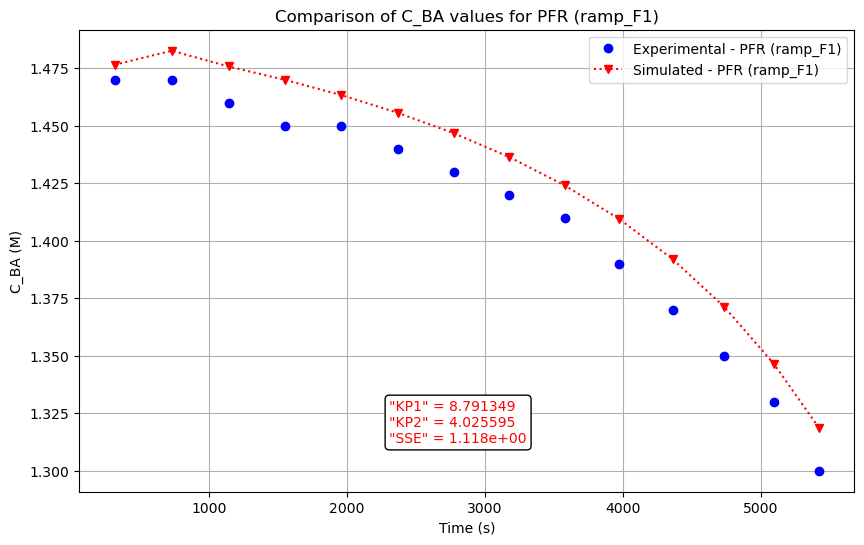

In [12]:
exp_num = 1  # number of experiment
exp_name = data_i = {1: "ramp_F1", 2: "ramp_F2", 3: "ramp_FT"}
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}
T0_i = {1: 119, 2: 139.4, 3: 139.2}
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
# Let's combine all the estimated theta values and their SSE values in a dictionary for each experiment

# estimated parameters and their SSE values
theta_pfr = {
    1: {
        "KP1": theta_ordered["KP1"],
        "KP2": theta_ordered["KP2"],
        "SSE": obj,
    },  # ramp_F1
}
# FOR NFE_T = 20 and NFE_Z = 20, we can simulate the model using the following code:
BA_exp_sim = SimulateTransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0=T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta=theta_pfr[exp_num],
    discr_method="dae.collocation",
    scheme="LAGRANGE-RADAU",
    nfe_t=40,
    nfe_z=20,
    ncp=2
)
model_sim = BA_exp_sim.get_labeled_model() 
# ``get_labeled_model()`` takes the instance and build a model for the  instance
solved_model = BA_exp_sim.simulate(tee=False)  # we can now simulate the model

# Extracting time points
t_con = BA_exp_sim.t_control
t_sim = (
    t_con * 60
)  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model


# Extract C_BA values from solved model
CBA_sim = np.array(
    [solved_model.C_BA[t, 20].value for t in t_con]
) 

# # FOR NFE_T = 30 and NFE_Z = 20, we can simulate the model using the following code:
# BA_exp_sim_40_20 = SimulateTransientPFR(
#     data=data_i[exp_num],
#     C_BA0=C_BA0_i[exp_num],
#     v0=v0_i[exp_num],
#     T0=T0_i[exp_num],
#     alpha_v=alpha_v_i[exp_num],
#     alpha_T=alpha_T_i[exp_num],
#     theta=theta_pfr[exp_num],
#     discr_method="dae.collocation",
#     scheme="LAGRANGE-RADAU",
#     nfe_t=40,
#     nfe_z=20,
#     ncp=2
# )
# model_sim_40_20 = BA_exp_sim_40_20.get_labeled_model()
# # get_labeled_model() takes the instance and build a model for the  instance
# solved_model_40_20 = BA_exp_sim_40_20.simulate(tee=False)  # we can now simulate the model


# CBA_sim_40_20 = np.array(
#     [solved_model_40_20.C_BA[t, 20].value for t in t_con]
# )

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_sim, data_i[exp_num]["C_BA(M)"], "ob", label=f"Experimental - PFR ({exp_name[exp_num]})")
ax.plot(t_sim, CBA_sim, "vr:", label=f"Simulated - PFR ({exp_name[exp_num]})")
ax.set_xlabel("Time (s)")
ax.set_ylabel("C_BA (M)")
ax.set_title(f"Comparison of C_BA values for PFR ({exp_name[exp_num]})")
ax.grid()
ax.legend()
# ax.set_ylim(1.25, 1.5)

# Adding parameter values and SSE value in the plot
annotation_text = f'"KP1" = {theta_pfr[exp_num]["KP1"]:0.6f} \n"KP2" = {theta_pfr[exp_num]["KP2"]:0.6f} \n"SSE" = {theta_pfr[exp_num]["SSE"]:0.3e}'
ax.text(
    0.40,
    0.20,
    annotation_text,
    transform=ax.transAxes,
    fontsize=10,
    color='red',
    verticalalignment="top",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

#### Heatmap
Let's draw a heatmap to visualize the correlation between the variables. FD gave better results than Collocation with Lagrange-Radau (LR). In LR the concentration profile at t=0-5 min band was not well captured.

Text(0, 0.5, 'Length of PFR (m)')

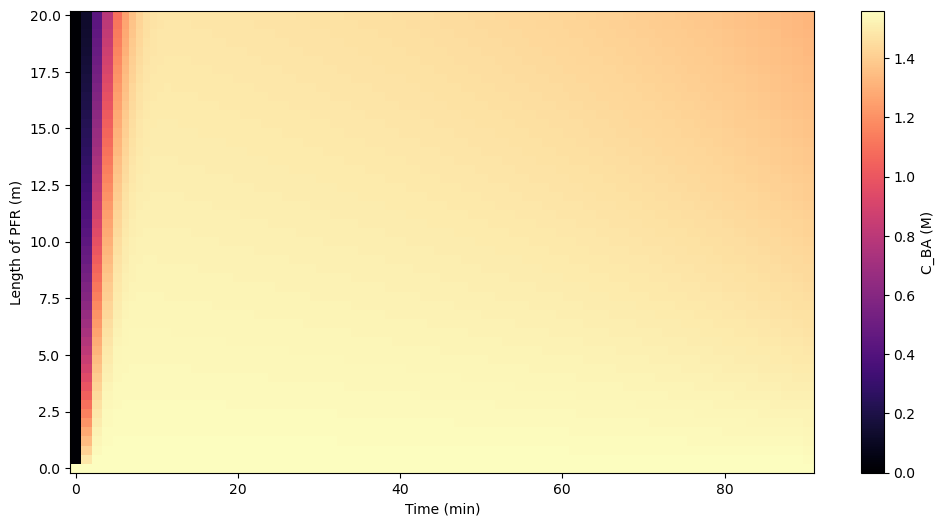

In [13]:
# select a methdod for discretization
# selected_method = "col" for collocation, "fd" for finite difference
exp_num=1
selected_method = "fd" 
method = {
    "col": {
        "discr": "dae.collocation",
        "scheme": "LAGRANGE-RADAU",
        "nfe_t": 40,
        "nfe_z": 20,
        "ncp": 2,
    },
    "fd": {
        "discr": "dae.finite_difference",
        "scheme": "BACKWARD",
        "nfe_t": 100,
        "nfe_z": 50,
        "ncp": 0,
    },
}

BA_exp_sim_40_20 = SimulateTransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0=T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta=theta_pfr[exp_num],
    discr_method=method[selected_method]["discr"],
    scheme=method[selected_method]["scheme"],
    nfe_t=method[selected_method]["nfe_t"],
    nfe_z=method[selected_method]["nfe_z"],
    ncp=method[selected_method]["ncp"],
)
model_sim_40_20 = BA_exp_sim_40_20.get_labeled_model()
# get_labeled_model() takes the instance and build a model for the  instance
solved_model_40_20 = BA_exp_sim_40_20.simulate(
    tee=False
)  # we can now simulate the model


# Heatmap
fig, ax = plt.subplots(figsize=(12, 6))
z_vals = np.array(solved_model_40_20.z)#[::3]
t_vals = np.array(solved_model_40_20.t)#t_con
# Create a meshgrid for the heatmap
t_grid, z_grid = np.meshgrid(t_vals, z_vals)
# Extract C_BA values for the heatmap
C_BA_tz = np.array(
    [[solved_model_40_20.C_BA[t, z].value for t in t_vals] for z in z_vals]
)
# Plot the heatmap
c = ax.pcolormesh(t_grid, z_grid, C_BA_tz, shading="auto", cmap="magma")
fig.colorbar(c, ax=ax, label="C_BA (M)")
ax.set_xlabel("Time (min)")
ax.set_ylabel("Length of PFR (m)")

### Multiple Experiment
Instead of estimating a parameter value for each of the parameters in each experiment, we will combine multiple experiments to estimate a single value for each of the parameters in parmest.

In [24]:
# exp_num = 2  # number of experiments to combine. 
# # Choose ``2`` for combining two ramp_F experiments.
# # Choose ``3`` for combining all the experiments.
# data_m = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
# C_BA0_m = {1: 1.56, 2: 1.55, 3: 1.56}
# T0_m = {1: 119, 2: 139.4, 3: 139.2}
# v0_m = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
# alpha_v_m = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
# alpha_T_m = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
# theta_initial_m = {
#     "KP1": 8.01758972730862,
#     "KP2": 3.7995866696746776,
# }  # theta value from ramp_F2 (using ``theta_ordered.to_dict()``). The parameter estimation is very senitive to this value.
# exp_list_pfr = []
# for i in range(1, exp_num + 1):
#     exp_list_pfr.append(TransientPFR(
#         data=data_m[i],
#         C_BA0=C_BA0_m[i],
#         v0=v0_m[i],
#         T0=T0_m[i],
#         alpha_v=alpha_v_m[i],
#         alpha_T=alpha_T_m[i],
#         theta_initial=  theta_initial_m,
#         discr_method="dae.finite_difference",
#         scheme="BACKWARD",
#         nfe_t=200,
#         nfe_z=50,
#         t_skip=1
#         ))
# # BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
# pest_m = parmest.Estimator(exp_list_pfr, obj_function='SSE', tee=False, solver_options={"linear_solver": "ma57", "max_iter": 100, "tol": 1e-5, })
# obj_m, theta_m = pest_m.theta_est()

# # printing model parameters
# print("Model Parameters")
# theta_ordered_m = theta_m.loc[['KP1', 'KP2']]
# print("theta values: ")
# print(theta_ordered_m)
# print("\nSSE value: ", obj_m)

#### Simulating with multiple experiment paramters

In [25]:
# exp_name = data_i = {1: 'ramp_F1', 2: 'ramp_F2', 3: 'ramp_FT'}
# data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
# C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}
# T0_i = {1: 119, 2: 139.4, 3: 139.2}
# v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
# alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
# alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
# theta_mul_exp = {1: {"KP1": 8.987939, "KP2": 7.464494, "SSE": 0.001570657722574639}}  # theta for the combined experiment
# t_skip=0
# for i in range(1, 4):
#     BA_exp_sim = SimulateTransientPFR(
#         data=data_i[i],
#         C_BA0=C_BA0_i[i],
#         v0=v0_i[i],
#         T0=T0_i[i],
#         alpha_v=alpha_v_i[i],
#         alpha_T=alpha_T_i[i],
#         theta=theta_ordered_m.to_dict(),
#         discr_method="dae.finite_difference",
#         scheme="BACKWARD",
#         nfe_t=100,
#         nfe_z=50,
#         t_skip=t_skip
#     )
#     model_sim = (
#         BA_exp_sim.get_labeled_model()
#     )  # get_labeled_model() takes the instance and build a model for the  instance
#     solved_model = BA_exp_sim.simulate(tee=False)  # we can now simulate the model

#     # Extracting time points
#     t_con = BA_exp_sim.t_control
#     t_sim = t_con * 60  # min to sec

#     # Extract C_BA values from solved model
#     CBA_sim = np.array([solved_model.C_BA[t, 20].value for t in t_con])

#     # Plotting
#     fig, ax = plt.subplots(figsize=(10, 6))
#     # Experimental data
#     ax.plot(
#         t_sim, data_i[i]["C_BA(M)"].iloc[t_skip:], "ob--", label=f"Experimental - PFR({exp_name[i]})"
#     )
#     # Simulated data
#     ax.plot(t_sim, CBA_sim, "vr:", label=f"Simulated - PFR({exp_name[i]})")

#     ax.set_xlabel("Time (s)")
#     ax.set_ylabel("C_BA (M)")
#     ax.set_title(f"Comparison of C_BA values for PFR ({exp_name[i]})")
#     ax.grid()
#     ax.legend()

## DOE (PDE)
we will use `doe.py` for the design of experiments for the PDE model.  
The data:

In [14]:
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}  # experimental data
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}  # M
T0_i = {1: 119, 2: 139.4, 3: 139.2}  # °C
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
# Estimated parameters for ramp_F1, ramp_F2, ramp_FT experiments from parmest
# Although "SSE" is not required, I kept it for reference
theta_pfr = {
    1: {
        "KP1": theta_ordered["KP1"],
        "KP2": theta_ordered["KP2"],
        "SSE": obj,
    },  # ramp_F1
}

The code to calculate the MBDOE design for a given set of parameters is given below:

In [15]:
exp_num = 1  # choose a experiment number between 1 to 3
# theta_pfr = {"KP1": 9.12, "KP2": 7.98, "SSE": 0.0008062096426552723}
exp_doe = TransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0= T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta_initial=theta_pfr[exp_num],
    discr_method="dae.collocation",
    scheme="LAGRANGE-RADAU",
    nfe_t=40,
    nfe_z=20,
    t_skip=0
)

doe_pfr = DesignOfExperiments(
    exp_doe,
    fd_formula="central",
    objective_option="determinant",
    scale_nominal_param_value=False,
    tee=False,
)

FIM_pfr = doe_pfr.compute_FIM()
print("FIM of the experiment using PFR Model:")
print(FIM_pfr)

det_FIM = np.linalg.det(FIM_pfr)
print("\nDeterminant of the FIM:", det_FIM)

print("\nCovariance of the parameters using PFR Model:")
cov_pfr = np.linalg.inv(FIM_pfr)
print(cov_pfr)

FIM of the experiment using PFR Model:
[[23.26073378 -2.66174014]
 [-2.66174014  0.3045846 ]]

Determinant of the FIM: 7.679082808835783e-07

Covariance of the parameters using PFR Model:
[[  396641.90235377  3466221.42686392]
 [ 3466221.42686392 30291031.30806736]]


### run_doe()

In [23]:
exp_num = 1  # choose a experiment number between 1 to 3
# theta_pfr = {"KP1": 9.12, "KP2": 7.98, "SSE": 0.0008062096426552723}
exp_doe = TransientPFR(
    data=data_i[exp_num],
    C_BA0=C_BA0_i[exp_num],
    v0=v0_i[exp_num],
    T0=T0_i[exp_num],
    alpha_v=alpha_v_i[exp_num],
    alpha_T=alpha_T_i[exp_num],
    theta_initial=theta_pfr[exp_num],
    discr_method="dae.collocation",
    scheme="LAGRANGE-RADAU",
    nfe_t=40,
    nfe_z=20,
    t_skip=0,
)
solver = pyo.SolverFactory("ipopt")
solver.options["tol"] = 1e-5
doe_exp = DesignOfExperiments(
    exp_doe,
    step=0.01,
    fd_formula="central",
    objective_option="trace",
    scale_nominal_param_value=False,
    solver=solver,
    tee=True,
    prior_FIM= FIM_pfr
)

FIM_pfr = doe_pfr.compute_FIM()
print("FIM of the experiment using PFR Model:")
print(FIM_pfr)

det_FIM = np.linalg.det(FIM_pfr)
print("\nDeterminant of the FIM:", det_FIM)

print("\nCovariance of the parameters using PFR Model:")
cov_pfr = np.linalg.inv(FIM_pfr)
print(cov_pfr)

FIM of the experiment using PFR Model:
[[23.26073378 -2.66174014]
 [-2.66174014  0.3045846 ]]

Determinant of the FIM: 7.679082808835783e-07

Covariance of the parameters using PFR Model:
[[  396641.90235377  3466221.42686392]
 [ 3466221.42686392 30291031.30806736]]


In [24]:
doe_exp.run_doe()

Ipopt 3.13.2: tol=1e-05


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. S

KeyboardInterrupt: 

### Full Factorial

In [28]:
# design_ranges = {
#     'C_BA0': [0.9, 1.56, 2],
#     'v0': [7.5e-6, 100e-6, 2],
#     'T0': [(70+273.15), (140+273.15), 2],
#     'alpha_v': [1e-11, 1.25e-6, 2],
#     'alpha_T': [0, 3, 2]
# }

# # prior FIM
# prior_FIM = np.array(FIM_pfr)
# # doe object for full factorial design
# solver = pyo.SolverFactory('ipopt')
# solver.options['max_iter'] = 200
# solver.options['tol'] = 1e-5
# solver.options['linear_solver']= 'ma57'
# doe_pfr_ff = DesignOfExperiments(
#     exp_doe,
#     fd_formula="central",
#     objective_option="determinant",
#     scale_nominal_param_value=False,
#     prior_FIM= prior_FIM,
#     solver=solver,
#     tee=False,
# )
# ff_res = doe_pfr_ff.compute_FIM_full_factorial(design_ranges= design_ranges)

### Fractional Factorial design
In this section, we need to change   

- ```n_points ```   $\rightarrow$ if we want to add more data points in between the design bounds
- ```var1```  $\rightarrow$  the first design variable we want to vary
- ```var2``` $\rightarrow$  the second design variable we want to vary

#### Data



In [29]:
exp_num = 1  # choose a experiment number between 1 to 3

data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}  # experimental data
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}  # M
T0_i = {1: 119, 2: 139.4, 3: 139.2}  # °C
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min

# prior FIM
pr_FIM = FIM_pfr

# number of points for the factorial design. DO NOT choose 0.
n_CBA = 10
n_v0 = 4
n_T0 = 9
n_alpha_v = 3
n_alpha_T = 1

# Range of design variables
C_BA0_FF = np.linspace(0.9, 1.56, n_CBA)  # M
v0_FF = np.linspace(7.51, 100, n_v0)  # µL/min
T0_FF = np.linspace(70, 140, n_T0)  # °C
alpha_v_FF = np.linspace(1e-5, 1.25, n_alpha_v)  # µL/min^2
alpha_T_FF = np.linspace(0, 3, n_alpha_T)  # °C/min

#### Computation

In [30]:
# The design variables as keys and their corresponding values as values in a dictionary.
design_var = {
    "C_BA0(M)": C_BA0_FF,
    "v0(µL/min)": v0_FF,
    "T0(°C)": T0_FF,
    "alpha_v(µL/min^2)": alpha_v_FF,
    "alpha_T(°C/min)": alpha_T_FF,
}

In [31]:
theta_pfr

{1: {'KP1': np.float64(8.791349277711594),
  'KP2': np.float64(4.02559468020612),
  'SSE': np.float64(1.1179160673214255)}}

In [31]:
# Choose arbitrary variables to vary from ``design_var``
selected_keys = [
    "C_BA0(M)",
    "T0(°C)",
    # "alpha_v(µL/min^2)",
    ]  

selected_vals = [design_var[key] for key in selected_keys]
grid_shape = [len(vals) for vals in selected_vals]

# Theta value
theta_est = theta_pfr[1]  # from ramp_F1 data

# Create the multi-dimensional arrays for FIM and optimality criteria
FIM_list = np.zeros((*grid_shape, 2, 2))  # Update based on parameter dimension
D_opt_list = np.zeros(grid_shape)
A_opt_list = np.zeros(grid_shape)
E_opt_list = np.zeros(grid_shape)
ME_opt_list = np.zeros(grid_shape)


# solver options
# solver = pyo.SolverFactory('ipopt')
# solver.options['max_iter'] = 200
# solver.options['tol'] = 1e-5
# solver.options['linear_solver']= 'ma27'
#! WARNING: changing the solver options to the ones above affect the results significantly

# Get all index combinations
for idx_tuple in product(*[range(n) for n in grid_shape]):
    values = [
        design_var[selected_keys[k]][idx_tuple[k]] for k in range(len(selected_keys))
    ]
    # ``idx_tuple`` creates index for each parameter combination
    # ``values`` is a list of selected design variable values for each combination

    # Create a dictionary to pass correct variables to TransientPFR
    design_kwargs = dict(zip(selected_keys, values))

    # Use default or fixed values for non-varied variables
    exp_doe = TransientPFR(
        data=data_i[exp_num],
        C_BA0=design_kwargs.get("C_BA0(M)", C_BA0_i[exp_num]),  # dict.get() returns default value if key not found
        # i.e., if "C_BA0(M)" is not in design_kwargs, will return C_BA0_i[exp_num] as default value
        v0=design_kwargs.get("v0(µL/min)", v0_i[exp_num]),
        T0=design_kwargs.get("T0(°C)", T0_i[exp_num]),
        alpha_v=design_kwargs.get("alpha_v(µL/min^2)", alpha_v_i[exp_num]),
        alpha_T=design_kwargs.get("alpha_T(°C/min)", alpha_T_i[exp_num]),
        theta_initial=theta_est,
        discr_method="dae.collocation",
        scheme="LAGRANGE-RADAU",
        nfe_t=25,
        nfe_z=20,
        ncp=2,
        t_skip=0,
    )

    doe_pfr = DesignOfExperiments(
        exp_doe,
        fd_formula="central",
        objective_option="determinant",
        scale_nominal_param_value=False,
        tee=False,
        prior_FIM=pr_FIM,
        # solver= solver,
    )

    FIM = np.array(doe_pfr.compute_FIM(method="kaug"))
    FIM_list[idx_tuple] = FIM

    # Compute optimality criteria
    D_opt_list[idx_tuple] = np.linalg.det(FIM)
    A_opt_list[idx_tuple] = np.trace(FIM)
    E_opt_list[idx_tuple] = np.linalg.eigvalsh(FIM)[0]
    ME_opt_list[idx_tuple] = np.linalg.cond(FIM)

 
D_opt_list_log10 = np.log10(D_opt_list)
A_opt_list_log10 = np.log10(A_opt_list)
E_opt_list_log10 = np.log10(E_opt_list)
ME_opt_list_log10 = np.log10(ME_opt_list)

In [33]:
D_opt_list_log10

array([[ 0.09485371,  0.19981339,  0.24619885,  0.20697766,  0.01400648,
        -0.61654761, -0.8221978 ,  0.46320124,  1.09438176],
       [ 0.16289185,  0.26785154,  0.314237  ,  0.27501581,  0.0820446 ,
        -0.54850963, -0.75415994,  0.53123941,  1.16241992],
       [ 0.22598541,  0.33094511,  0.37733057,  0.33810938,  0.14513816,
        -0.4854162 , -0.69106661,  0.59433299,  1.22551352],
       [ 0.28480465,  0.38976435,  0.43614981,  0.39692862,  0.20395739,
        -0.42659707, -0.63224754,  0.65315223,  1.28433278],
       [ 0.33989212,  0.44485183,  0.49123729,  0.4520161 ,  0.25904486,
        -0.37150968, -0.57716023,  0.70823972,  1.33942027],
       [ 0.39169325,  0.49665295,  0.54303842,  0.50381722,  0.31084598,
        -0.31970863, -0.52535924,  0.76004086,  1.39122141],
       [ 0.44057815,  0.54553786,  0.59192332,  0.55270213,  0.35973088,
        -0.27082378, -0.47647445,  0.80892577,  1.44010632],
       [ 0.48685774,  0.59181745,  0.63820292,  0.59898172,  0

Finding the design variable values from the optimality criteria

In [34]:
opt_designs = {}
for key, opt_value in {"D_opt": D_opt_list, "A_opt":A_opt_list, "E_opt": E_opt_list, "ME_opt": ME_opt_list}.items():
    opt_val_wo_nan = opt_value.copy()
    nan_idx = np.isnan(opt_val_wo_nan)
    # Find the maximum value of the optimization for D, A and E and minimum value for ME-optimality
    if key != "ME_opt":
        opt_val_wo_nan[nan_idx] = - np.inf
        max_idx = np.unravel_index(np.argmax(opt_val_wo_nan), opt_val_wo_nan.shape)
    else:
        opt_val_wo_nan[nan_idx] = np.inf
        max_idx = np.unravel_index(np.argmin(opt_val_wo_nan), opt_val_wo_nan.shape)

    # Store the optimal designs for D, A, E and ME-optimality in a dictionary
    opt_designs[key] = {k: design_var[k][idx] for k, idx in zip(selected_keys, max_idx)} 
    
# print the optimal designs for D, A, E and ME-optimality
opt_designs

{'D_opt': {'C_BA0(M)': np.float64(1.56), 'T0(°C)': np.float64(140.0)},
 'A_opt': {'C_BA0(M)': np.float64(1.56), 'T0(°C)': np.float64(140.0)},
 'E_opt': {'C_BA0(M)': np.float64(1.56), 'T0(°C)': np.float64(140.0)},
 'ME_opt': {'C_BA0(M)': np.float64(1.56), 'T0(°C)': np.float64(78.75)}}

### Parallel Computation of factorial design

In [25]:
from joblib import Parallel, delayed

In [26]:
exp_num = 1  # choose a experiment number between 1 to 3

data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}  # experimental data
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}  # M
T0_i = {1: 119, 2: 139.4, 3: 139.2}  # °C
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min

# prior FIM
pr_FIM = FIM_pfr

# number of points for the factorial design. DO NOT choose 0.
n_CBA = 10
n_v0 = 4
n_T0 = 9
n_alpha_v = 3
n_alpha_T = 1

# Range of design variables
C_BA0_FF = np.linspace(0.9, 1.56, n_CBA)  # M
v0_FF = np.linspace(7.51, 100, n_v0)  # µL/min
T0_FF = np.linspace(70, 140, n_T0)  # °C
alpha_v_FF = np.linspace(1e-5, 1.25, n_alpha_v)  # µL/min^2
alpha_T_FF = np.linspace(0, 3, n_alpha_T)  # °C/min

In [27]:
# The design variables as keys and their corresponding values as values in a dictionary.
design_var = {
    "C_BA0(M)": C_BA0_FF,
    "v0(µL/min)": v0_FF,
    "T0(°C)": T0_FF,
    "alpha_v(µL/min^2)": alpha_v_FF,
    "alpha_T(°C/min)": alpha_T_FF,
}

In [29]:
# Choose arbitrary variables to vary from ``design_var``
selected_keys = [
    "C_BA0(M)",
    "T0(°C)",
    # "alpha_v(µL/min^2)",
]

# Choose arbitrary variables to vary from ``design_var``
selected_keys = [
    "C_BA0(M)",
    "T0(°C)",
    # "alpha_v(µL/min^2)",
]

selected_vals = [design_var[key] for key in selected_keys]
grid_shape = [len(vals) for vals in selected_vals]

# Theta value
theta_est = theta_pfr[1]  # from ramp_F1 data

# Create the multi-dimensional arrays for FIM and optimality criteria
FIM_list = np.zeros((*grid_shape, 2, 2))  # Update based on parameter dimension
D_opt_list = np.zeros(grid_shape)
A_opt_list = np.zeros(grid_shape)
E_opt_list = np.zeros(grid_shape)
ME_opt_list = np.zeros(grid_shape)

# Prepare the index grid
index_grid = list(product(*[range(n) for n in grid_shape]))


def compute_FIM_for_design(idx_tuple):
    values = [
        design_var[selected_keys[k]][idx_tuple[k]] for k in range(len(selected_keys))
    ]
    design_kwargs = dict(zip(selected_keys, values))

    exp_doe = TransientPFR(
        data=data_i[exp_num],
        C_BA0=design_kwargs.get("C_BA0(M)", C_BA0_i[exp_num]),
        v0=design_kwargs.get("v0(µL/min)", v0_i[exp_num]),
        T0=design_kwargs.get("T0(°C)", T0_i[exp_num]),
        alpha_v=design_kwargs.get("alpha_v(µL/min^2)", alpha_v_i[exp_num]),
        alpha_T=design_kwargs.get("alpha_T(°C/min)", alpha_T_i[exp_num]),
        theta_initial=theta_est,
        discr_method="dae.collocation",
        scheme="LAGRANGE-RADAU",
        nfe_t=25,
        nfe_z=20,
        ncp=2,
        t_skip=0,
    )

    doe_pfr = DesignOfExperiments(
        exp_doe,
        fd_formula="central",
        objective_option="determinant",
        scale_nominal_param_value=False,
        tee=False,
        prior_FIM=pr_FIM,
    )

    FIM = np.array(doe_pfr.compute_FIM(method="kaug"))

    return (
        idx_tuple,
        FIM,
        np.linalg.det(FIM),
        np.trace(FIM),
        np.linalg.eigvalsh(FIM)[0],
        np.linalg.cond(FIM),
    )


# Run in parallel using all cores
results = Parallel(n_jobs=-1)(
    delayed(compute_FIM_for_design)(idx) for idx in index_grid
)

# Fill the result arrays
for idx, FIM, D_opt, A_opt, E_opt, ME_opt in results:
    FIM_list[idx] = FIM
    D_opt_list[idx] = D_opt
    A_opt_list[idx] = A_opt
    E_opt_list[idx] = E_opt
    ME_opt_list[idx] = ME_opt

# Convert to log scale
D_opt_list_log10 = np.log10(D_opt_list)
A_opt_list_log10 = np.log10(A_opt_list)
E_opt_list_log10 = np.log10(E_opt_list)
ME_opt_list_log10 = np.log10(ME_opt_list)

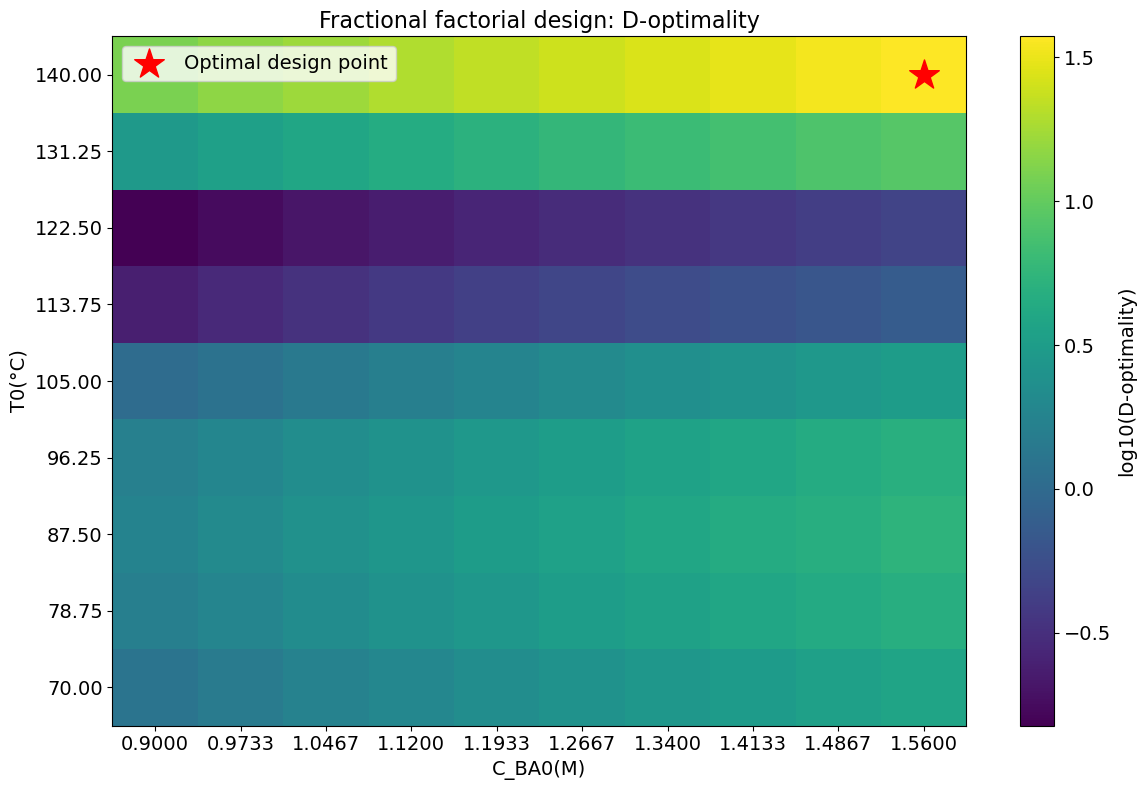

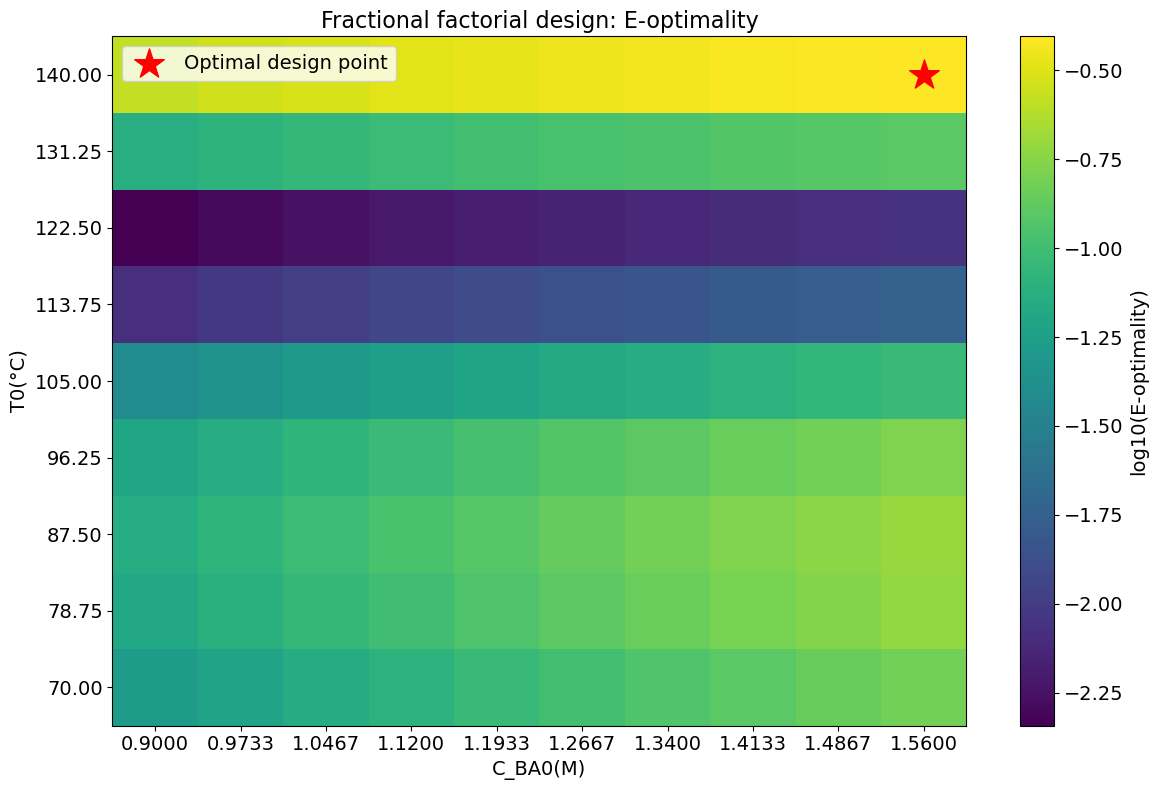

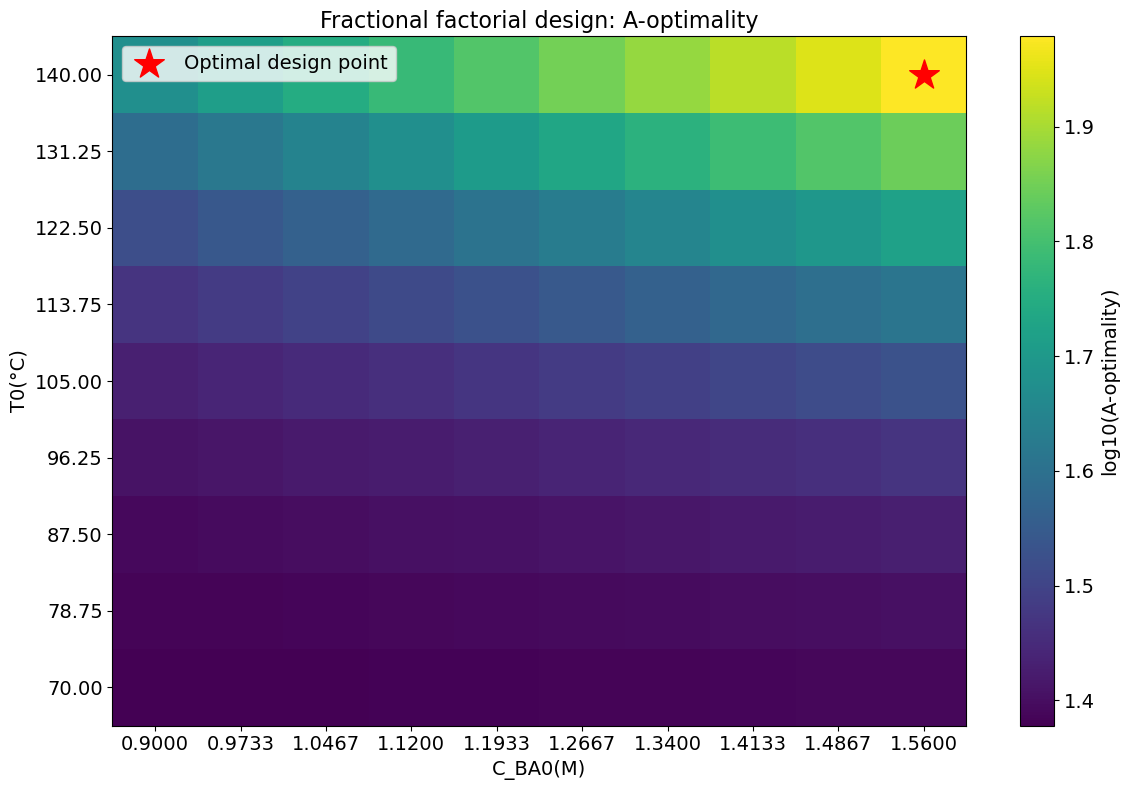

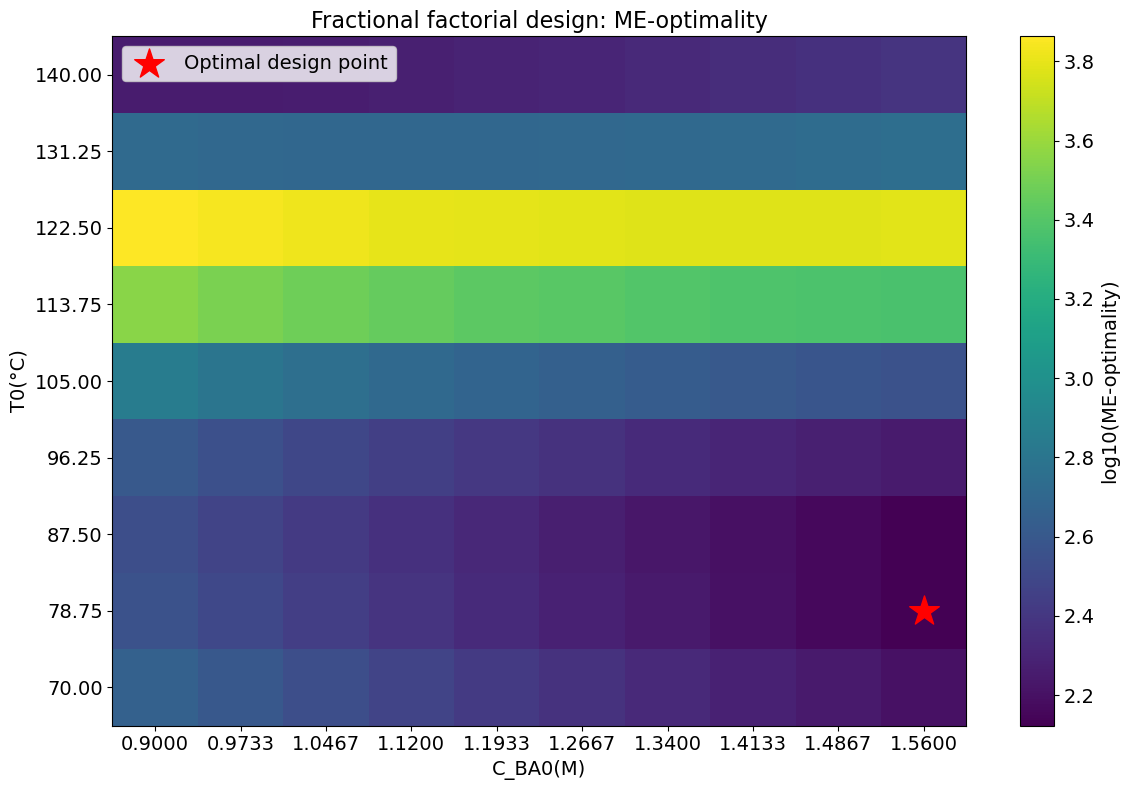

In [30]:
# Create a meshgrid for pcolormesh
C_mesh, T_mesh = np.meshgrid(C_BA0_FF, T0_FF, indexing="ij")
heatmaps_list = [
    (D_opt_list_log10, "D-optimality"),
    (E_opt_list_log10, "E-optimality"),
    (A_opt_list_log10, "A-optimality"),
    (ME_opt_list_log10, "ME-optimality"),
]

for data, title in heatmaps_list:
    plt.figure(figsize=(12, 8))
    pc = plt.pcolormesh(C_mesh, T_mesh, data, shading="auto", cmap="viridis")

    # find the index of the optimum design point
    if title == "ME-optimality":
        index = np.unravel_index(np.argmin(data), data.shape)
    else:
        index = np.unravel_index(np.argmax(data), data.shape)

    plt.scatter(
        design_var[selected_keys[0]][index[0]],
        design_var[selected_keys[1]][index[1]],
        marker="*",
        s=500,
        color="red",
        label="Optimal design point",
    )
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel(selected_keys[0], fontsize=14)
    plt.ylabel(selected_keys[1], fontsize=14)
    plt.xticks(design_var[selected_keys[0]], fontsize=14)
    plt.yticks(design_var[selected_keys[1]], fontsize=14)
    cbar = plt.colorbar(pc)
    cbar.set_label(label=f"log10({title})", fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.title(f"Fractional factorial design: {title}", fontsize=16)
    plt.tight_layout()

Parallel computation ends here. The plot below is from the fractional factorial computation from before.

#### Plotting heatmap
We will plot different optimality crieteria values for different designs using a heatmap by selecting only C_BA0 and T0 as the design variables to vary.

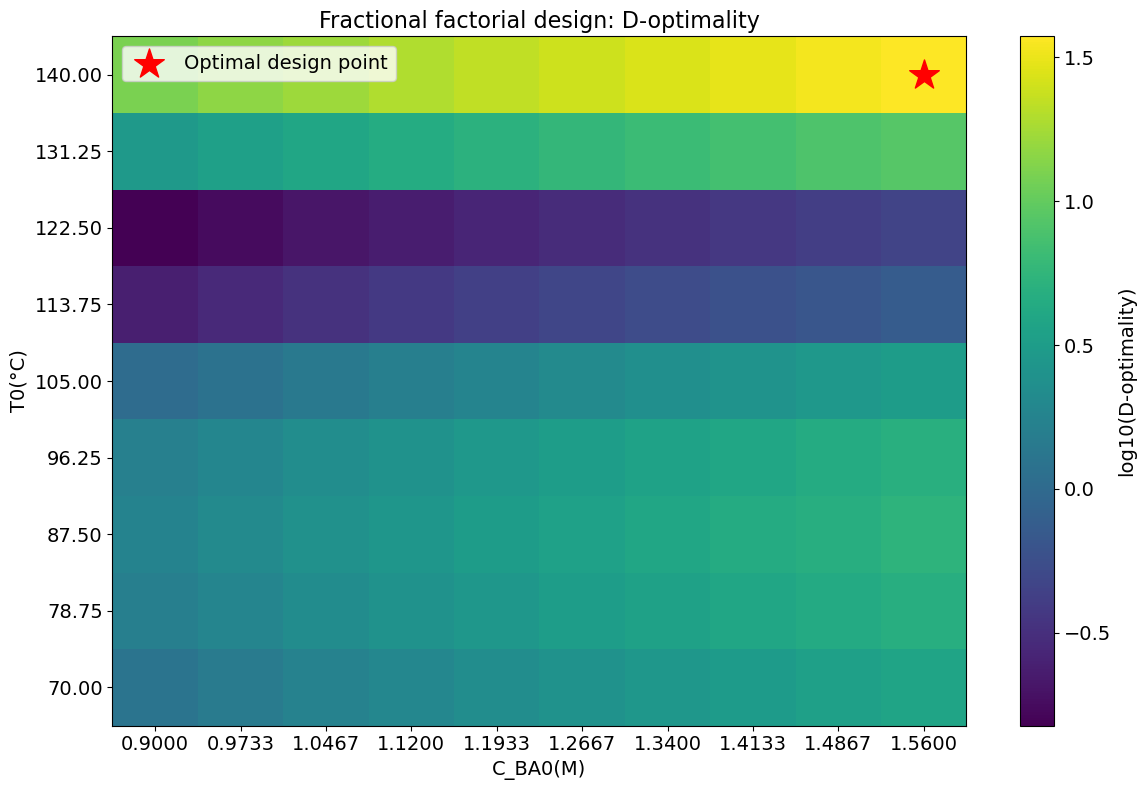

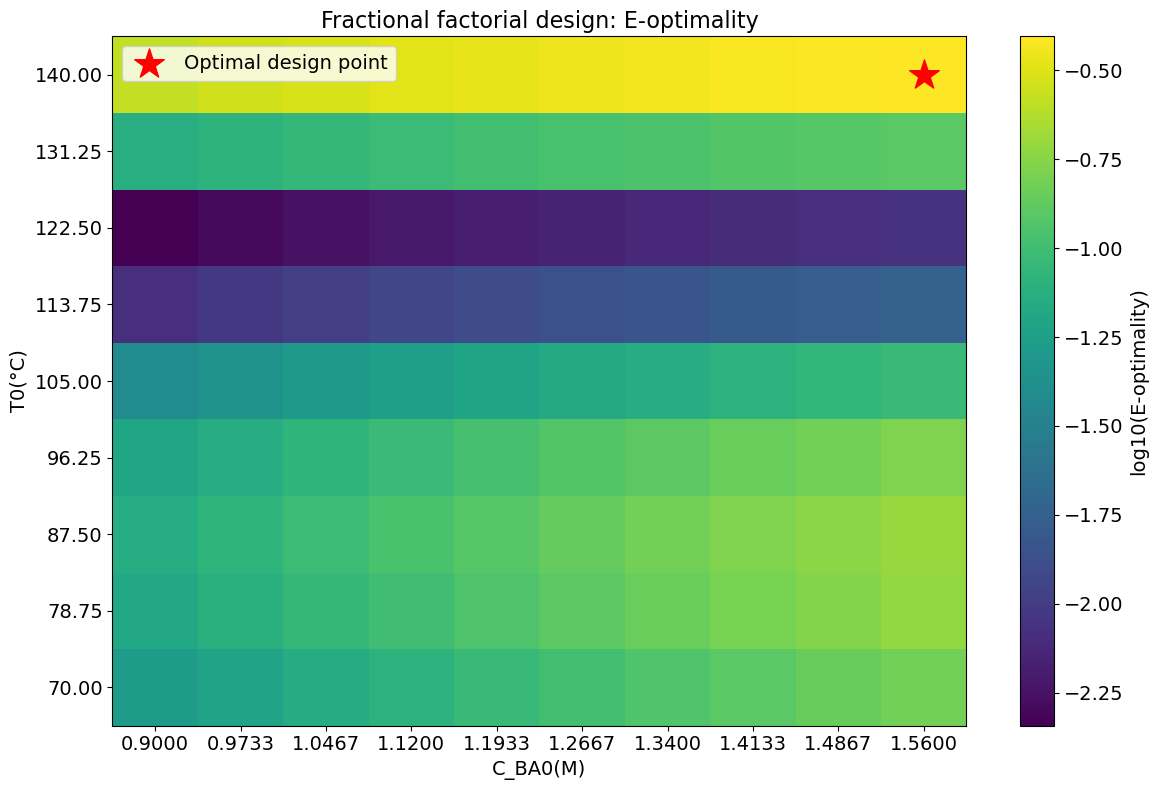

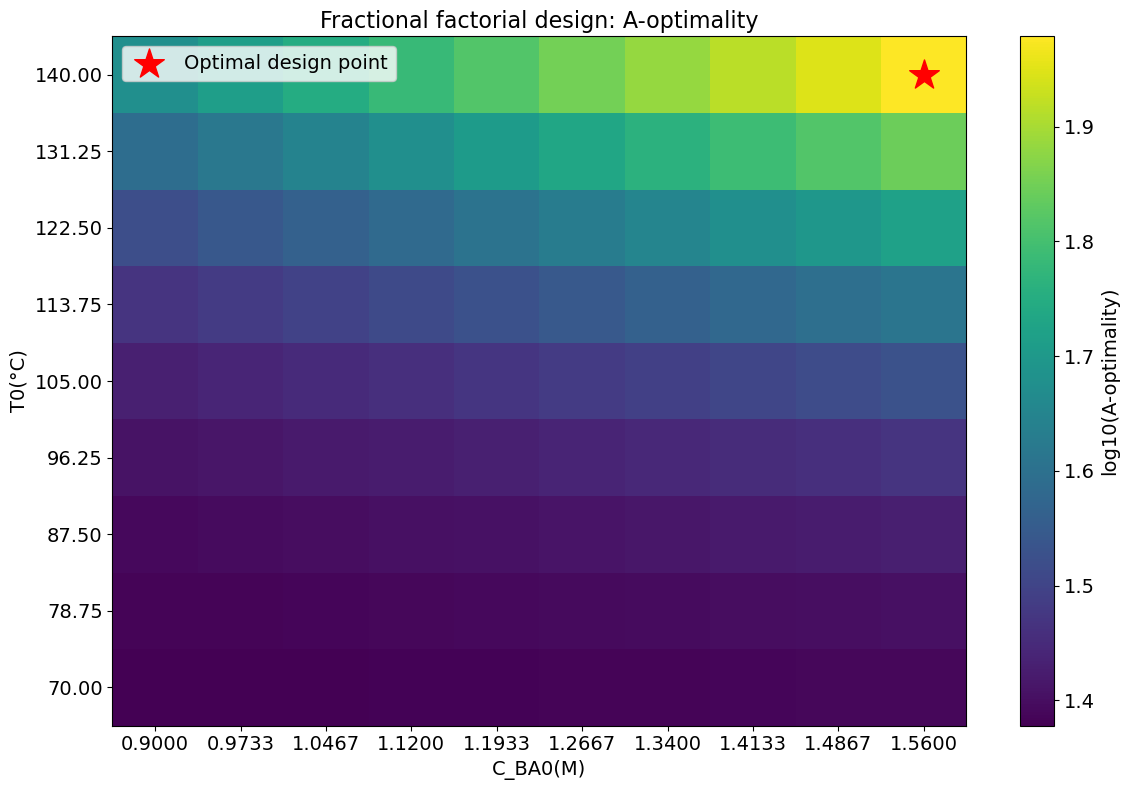

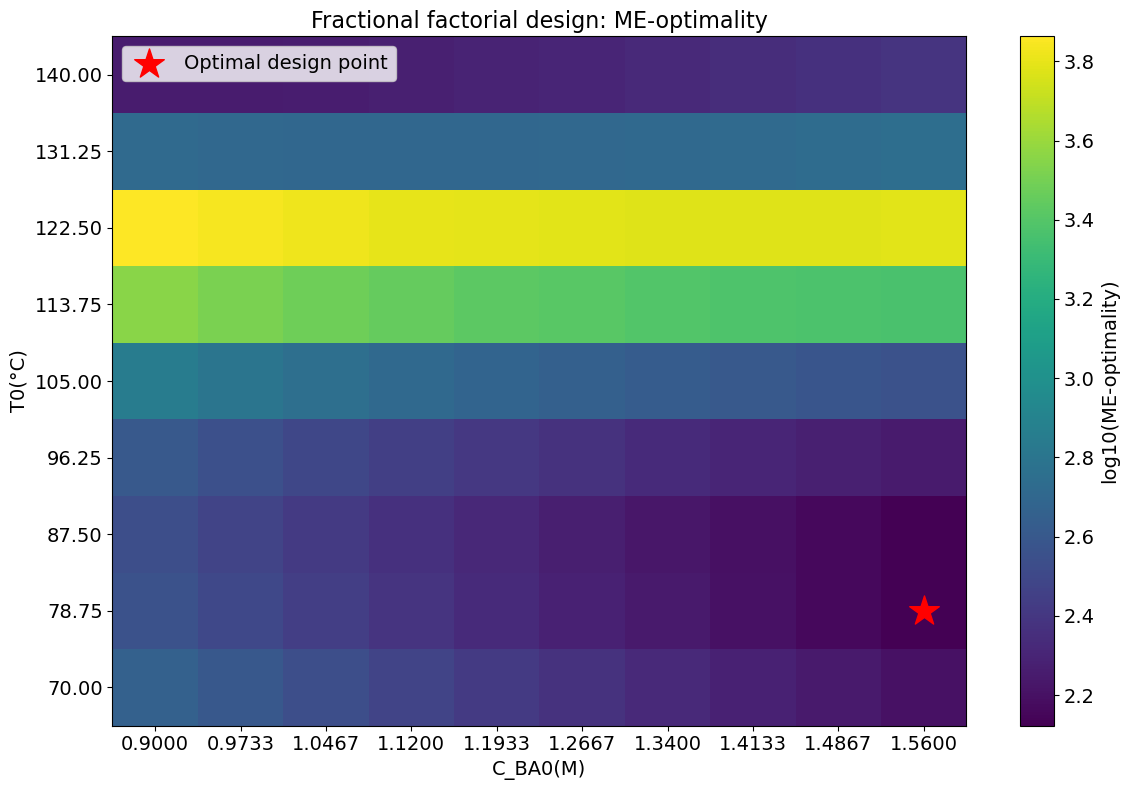

In [35]:
# Create a meshgrid for pcolormesh
C_mesh, T_mesh = np.meshgrid(C_BA0_FF, T0_FF, indexing="ij")
heatmaps_list = [
    (D_opt_list_log10, "D-optimality"),
    (E_opt_list_log10, "E-optimality"),
    (A_opt_list_log10, "A-optimality"),
    (ME_opt_list_log10, "ME-optimality"),
]

for data, title in heatmaps_list:
    plt.figure(figsize=(12, 8))
    pc = plt.pcolormesh(C_mesh, T_mesh, data, shading="auto", cmap="viridis")

    # find the index of the optimum design point
    if title == "ME-optimality":
        index = np.unravel_index(np.argmin(data), data.shape)
    else:
        index = np.unravel_index(np.argmax(data), data.shape)

    plt.scatter(
        design_var[selected_keys[0]][index[0]],
        design_var[selected_keys[1]][index[1]],
        marker="*",
        s=500,
        color="red",
        label="Optimal design point",
    )
    plt.legend(loc="upper left", fontsize=14)
    plt.xlabel(selected_keys[0], fontsize=14)
    plt.ylabel(selected_keys[1], fontsize=14)
    plt.xticks(design_var[selected_keys[0]], fontsize=14)
    plt.yticks(design_var[selected_keys[1]], fontsize=14)
    cbar = plt.colorbar(pc)
    cbar.set_label(label=f"log10({title})", fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.title(f"Fractional factorial design: {title}", fontsize=16)
    plt.tight_layout()

From the Optimality heatmaps above we can see that the best experimental design is T0 = 140°C and C_BA0 = 1.56 M. This makes sense since the measurement errors are 0.030 M for BA and 0.0165 M, so a higher concentration of BA would make the % of error smaller. Also we need a different temperature since we have temperature dependent term here and since at higer temperature the reaction rate is higher, we will get higher conenctration of EB which will then have smaller % of measurement error.

### Optimize FIM

In [36]:
# class TransientPFRrunDoE(Experiment):
#     def __init__(
#         self,
#         data,
#         C_BA0,
#         v0,
#         T0,
#         alpha_v,
#         alpha_T=0,
#         theta_initial=None,
#         discr_method="dae.finite_difference",
#         scheme="BACKWARD",
#         nfe_t=40,
#         nfe_z=20,
#         ncp=3,
#         t_skip=1,
#     ):
#         """
#         Parameters:
#             data: data of the experiment. dtype: pandas dataframe.
#             C_BA0: initial concentration of benzoic acid, M
#             v0: initial flowrate, µL/min
#             T0: initial temperature, °C
#             alpha_v: flowrate ramping rate, µL/min^2
#             alpha_T: temperature ramping rate, °C/min^2
#             theta_initial: initial theta value, dimensionless
#             discr_method: discretization method, string. Options: "dae.collocation", "dae.finite_difference", "dae.finite_difference". default: "dae.finite_difference"
#             scheme: discretization scheme for "dae.finite_difference", string. Options: "BACKWARD", "FORWARD". default: "BACKWARD"
#             nfe_t: number of finite elements for time, integer. default: 50
#             nfe_z: number of finite elements for length, integer. default: 50
#             ncp: number of collocation points, integer. default: None
#             t_skip: time points to skip, integer. default: 1
#         """
#         self.data = data
#         self.C_BA0 = C_BA0
#         self.v0 = v0 * 1e-6  # µL/min to L/min
#         self.T0 = T0 + 273.15  # °C to K
#         self.alpha_v = alpha_v * 1e-6  # µL/min^2 to L/min^2
#         self.alpha_T = alpha_T
#         self.discr_method = discr_method
#         self.scheme = scheme
#         self.nfe_t = nfe_t
#         self.nfe_z = nfe_z
#         self.ncp = ncp
#         self.model = None
#         self.t_skip = t_skip

#         # Constants
#         self.AREA = 4.908738521234052e-06  # dm^2
#         self.BA_MEAS_ERR = 0.030  # M, measurement error (std) for benzoic acid
#         self.EB_MEAS_ERR = 0.0165  # M, measurement error (std) for ethyl benzene. although not required.
#         self.SEC2MIN = 1 / 60  # second to minute conversion factor.
#         self.R = 8.314462618  # Universal gas constant, J/(mol-K)
#         self.TM = 378.15  # average temperature of the reactor, K
#         self.t_in = (
#             self.data.loc[0, "t_in(s)"] * self.SEC2MIN
#         )  # min, the time point the sample entered the PFR
#         if (
#             self.alpha_T != 0
#         ):  # Note: This is used b/c the t_L data for FT case is weird.
#             self.t_control = (
#                 self.data.loc[self.t_skip :, "t_in(s)"]
#                 + self.data.loc[self.t_skip :, "tau(s)"]
#             ) * self.SEC2MIN  # min, the time points the sample left the PFR
#         else:
#             self.t_control = (
#                 self.data.loc[self.t_skip :, "t_L(s)"]
#             ) * self.SEC2MIN  # min, the time points the sample left the PFR

#         """
#         we will ignore the first time point when the sample lefts the PFR. the PFR was initially empty, we should get a 
#         sharp discontinuous jump in concentration when C_BA goes from zero to some value. However, when solving pde, 
#         we won't get that sharp jump, it will be a smooth curve.For a sharp curve we need a step size of 0, or 
#         nfe= infinity. So, we will ignore the first time point, b/c the first point concentration will be much 
#         less than the actual conentration.  For the rest of the time points, we won't have this discontinuous
#         jump and the concentration change will be smooth.
#         """
#         self.t_upper = (
#             self.t_control.max()
#         )  # min, upper bound of the ContinuousSet time

#         if theta_initial is None:
#             theta_initial = {"KP1": 9.12, "KP2": 7.98}
#         self.theta_initial = theta_initial

#     def get_labeled_model(self):
#         if self.model is None:
#             self.create_model()
#             self.finalize_model()
#             self.label_experiment()
#         return self.model

#     # ============================================================================================================================
#     def create_model(self):
#         # model
#         m = self.model = pyo.ConcreteModel("Transient PFR model")

#         # continuous set
#         m.t = ContinuousSet(bounds=(0, self.t_upper), initialize=self.t_control)  # min
#         m.z = ContinuousSet(bounds=(0, 20))  # length of the reactor, dm
#         # we are not including the length of the pipe to the reactor and the pipe from the reactor to the detector.

#         # Define variables
#         m.C_BA = pyo.Var(
#             m.t, m.z, initialize=self.C_BA0
#         )  # benzoic acid concentration in M
#         m.C_EB = pyo.Var(m.t, m.z, initialize=0)  # ethyl benzene concentration in M
#         m.T0 = pyo.Var(
#             bounds=((70 + 273.15), (140 + 273.15)), initialize=self.T0
#         )  # initial temperature, K
#         m.T = pyo.Var(m.t, initialize=self.T0)  # temperature, K
#         m.v0 = pyo.Var(
#             bounds=(7.5e-6, 100e-6), initialize=self.v0
#         )  # initial flowrate in L/min
#         m.v = pyo.Var(m.t, initialize=self.v0)  # flowrate in L/min

#         # Define derivative variables
#         m.dC_BA_dt = DerivativeVar(m.C_BA, wrt=m.t)
#         m.dC_BA_dz = DerivativeVar(m.C_BA, wrt=m.z)

#         # Define unknown parameters that need to be estimated
#         m.KP1 = pyo.Var(bounds=(0, 10))  # dimensionless
#         m.KP2 = pyo.Var(bounds=(0, 10))  # J/mol

#         # Expressions
#         # equation for pre-exponential factor, k0
#         m.k0 = pyo.Expression(
#             expr=pyo.exp(-m.KP1 + m.KP2 * 10000 / (self.R * self.TM))
#         )  # sec^(-1)
#         # equation for activation energy, EA
#         m.EA = pyo.Expression(expr=m.KP2 * 10000)  # J/mol

#         # equation for the Arrhenius equation
#         @m.Expression(m.t)
#         def k(m, t):
#             return (
#                 pyo.exp(-m.KP1 - (m.KP2 * 10000 / self.R) * (1 / m.T[t] - 1 / self.TM))
#                 / self.SEC2MIN
#             )  # min^(-1)

#         # Define the partial differential equations (PDE)
#         @m.Constraint(m.t, m.z)
#         def _pde_eqn(m, t, z):
#             if z == 0:
#                 return pyo.Constraint.Skip
#             else:
#                 return (
#                     m.dC_BA_dt[t, z]
#                     == -(m.v[t] / self.AREA) * m.dC_BA_dz[t, z] - m.k[t] * m.C_BA[t, z]
#                 )

#         # ramping the flowrate
#         @m.Constraint(m.t)
#         def flowrate_ramp(m, t):
#             return m.v[t] == m.v0 - self.alpha_v * t  # L/min.
#             # Note: only `self.t_in` is converted to min, b/c `m.t` is already in min.

#         # ramping the temperature
#         @m.Constraint(m.t)
#         def Temperature_ramp(m, t):
#             return m.T[t] == m.T0 - self.alpha_T * t  # K

#         @m.Constraint(m.t, m.z)
#         def _EB_conc(m, t, z):
#             return self.C_BA0 == m.C_BA[t, z] + m.C_EB[t, z]  # M.

#     # ============================================================================================================================
#     def finalize_model(self):
#         m = self.model

#         # fixing the unknown parameter values
#         m.KP1.fix(self.theta_initial["KP1"])
#         m.KP2.fix(self.theta_initial["KP2"])

#         # Discretizing the model
#         if self.discr_method == "dae.finite_difference":
#             pyo.TransformationFactory(self.discr_method).apply_to(
#                 m, nfe=self.nfe_t, scheme=self.scheme, wrt=m.t
#             )  # discretize wrt time

#             pyo.TransformationFactory(self.discr_method).apply_to(
#                 m, nfe=self.nfe_z, scheme=self.scheme, wrt=m.z
#             )  # discretize wrt length

#         elif self.discr_method == "dae.collocation":
#             pyo.TransformationFactory(self.discr_method).apply_to(
#                 m, nfe=self.nfe_t, ncp=self.ncp, scheme=self.scheme, wrt=m.t
#             )  # discretize wrt time

#             pyo.TransformationFactory(self.discr_method).apply_to(
#                 m, nfe=self.nfe_z, ncp=self.ncp, scheme=self.scheme, wrt=m.z
#             )  # discretize wrt length

#         else:
#             raise TypeError(
#                 "Invalid discretization method. Options: 'dae.collocation', 'dae.finite_difference'"
#             )

#         # Let's define initial conditions for z>0
#         for z in m.z:
#             m.C_BA[0, z].fix(0)  # M

#         # Let's define initial conditions for z=0 / fixing the decision variable
#         for t in m.t:
#             if t >= self.t_in:  # after the feed enters the PFR
#                 m.C_BA[t, 0].fix(self.C_BA0)
#                 # set upper limit and lower bounds for C_BA at reactor inlet
#                 m.C_BA[t, 0].setlb(0.9)  # M
#                 m.C_BA[t, 0].setub(1.56)  # M
#             else:
#                 m.C_BA[t, 0].fix(0)  # M

#         # Fix the decision variables T0 and v0
#         m.T0.fix(self.T0)  # K
#         m.v0.fix(self.v0)  # L/min

#     # =================================================================================================================
#     def label_experiment(self):
#         m = self.model

#         # Experiment outputs
#         m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.experiment_outputs.update(
#             (m.C_BA[t, 20], self.data.loc[(ind + self.t_skip), "C_BA(M)"])
#             for ind, t in enumerate(self.t_control)
#         )  # we also need to shift the value by `self.t_skip`
#         m.experiment_outputs.update(
#             (m.C_EB[t, 20], self.data.loc[(ind + self.t_skip), "C_EB(M)"])
#             for ind, t in enumerate(self.t_control)
#         )
#         # Experiment inputs / control variables
#         m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.experiment_inputs.update(
#             (m.C_BA[t, 0], None) for t in self.t_control
#         )  # we have already set the input as ``m.C_BA[t, 0].fix(self.C_BA0)``.
#         # and we won't set it again. you can also set any value here instead of ``None``, and the result will be the same.
#         # So, it doesn't care about this value
#         # Note: if the decision variable is not a set, rather a scalar, then use the square bracket notation for mapping
#         # e.g. m.experiment_inputs.update([(m.C_BA[t, 0], None)]) . same applies for other experimental data, outputs etc
#         m.experiment_inputs[m.v0] = None
#         m.experiment_inputs[m.T0] = None

#         # Experimental measurement error
#         m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.measurement_error.update(
#             (m.C_BA[t, 20], self.BA_MEAS_ERR) for t in self.t_control
#         )
#         m.measurement_error.update(
#             (m.C_EB[t, 20], self.EB_MEAS_ERR) for t in self.t_control
#         )
#         # m.measurement_error[m.v0] = 0.01  # L/min
#         # m.measurement_error[m.T0] = 0.01  # K

#         # Unknown parameters
#         m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
#         m.unknown_parameters.update((p, pyo.value(p)) for p in [m.KP1, m.KP2])
#         # ============================================================================================

In [37]:
# exp_num = 1  # choose a experiment number between 1 to 3
# # theta_pfr = {"KP1": 9.12, "KP2": 7.98, "SSE": 0.0008062096426552723}
# exp_doe = TransientPFRrunDoE(
#     data=data_i[exp_num],
#     C_BA0=v1[index[0]],
#     v0=v0_i[exp_num],
#     T0=v2[index[1]],
#     alpha_v=alpha_v_i[exp_num],
#     alpha_T=alpha_T_i[exp_num],
#     theta_initial=theta_pfr[exp_num],
#     discr_method="dae.collocation",
#     scheme="LAGRANGE-RADAU",
#     nfe_t=25,
#     nfe_z=15,
#     ncp=2,
#     t_skip=0,
# )
# # solver options
# solver = pyo.SolverFactory("ipopt")
# solver.options["linear_solver"] = "ma57"
# solver.options["max_iter"] = 100
# solver.options["tol"] = 1e-5

# doe_pfr = DesignOfExperiments(
#     exp_doe,
#     fd_formula="central",
#     objective_option="determinant",
#     scale_nominal_param_value=False,
#     tee=False,
#     solver=solver,
#     prior_FIM=np.array([
#         [27.90353664, -3.19240565], 
#         [-3.19240565, 0.36523883]]
#         ),
# )

# FIM_pfr = doe_pfr.compute_FIM()
# print("FIM of the experiment using PFR Model:")
# print(FIM_pfr)

# det_FIM = np.linalg.det(FIM_pfr)
# print("\nDeterminant of the FIM:", det_FIM)

# print("\nCovariance of the parameters using PFR Model:")
# cov_pfr = np.linalg.inv(FIM_pfr)
# print(cov_pfr)

In [38]:
# doe_pfr.run_doe()

In [39]:
# doe_pfr.model.scenario_blocks[0]

In [40]:
# doe_pfr.results

For **isothermal experiments, the FIM is practically singular**. It is b/c we have a temperature dependence term in the model. So it is not possible to find the temperature dependent parameters to estimate from the isothermal experiment.  

Since the FIM is singular, it means for isothermal experiments, the log-likelihood surface is flat near the optimum, i.e., small changes in the parameter values do not change the likelihood much. Therefore, the model has many nearby parameters as good as the optimum. Another reason coulbe be that the parameters are highly correlated.    

For non-isothermal experiments, the FIM is not singular. So the log-likelihood surface is not flat near the optimum.

## Sequential experiments (2 ramp-F experiments)
Here, we will use the PFR model to estimate the parameters for sequential experiments using Parmest and then use the DOE to estimate the optimal design.
###  Parameter estimation using Parmest for sequential experiments

In [41]:
exp_num = 2  # number of experiments to combine.
# Choose ``2`` for combining two ramp_F experiments.
# Choose ``3`` for combining all the experiments.
data_m = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
C_BA0_m = {1: 1.56, 2: 1.55, 3: 1.56}
T0_m = {1: 119, 2: 139.4, 3: 139.2}
v0_m = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_m = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_m = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
theta_initial_m = {
    "KP1": 8.01758972730862,
    "KP2": 3.7995866696746776,
}  # theta value from ramp_F2 (using ``theta_ordered.to_dict()``). The parameter estimation is very senitive to this value.
exp_list_pfr = []
for i in range(1, exp_num + 1):
    exp_list_pfr.append(TransientPFR(
        data=data_m[i],
        C_BA0=C_BA0_m[i],
        v0=v0_m[i],
        T0=T0_m[i],
        alpha_v=alpha_v_m[i],
        alpha_T=alpha_T_m[i],
        theta_initial=  theta_initial_m,
        discr_method="dae.collocation",
        scheme="LAGRANGE-RADAU",
        nfe_t=40,
        nfe_z=20,
        ncp=2,
        t_skip=0
        ))
# BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
pest_m = parmest.Estimator(exp_list_pfr, obj_function='SSE', tee=False, solver_options={"linear_solver": "ma57", "max_iter": 200})
obj_m2, theta_m2 = pest_m.theta_est()

# printing model parameters
print("Model Parameters")
theta_ordered_m2 = theta_m2.loc[['KP1', 'KP2']]
print("theta values: ")
print(theta_ordered_m2)
print("\nSSE value: ", obj_m2)

Model Parameters
theta values: 
KP1    9.297276
KP2    8.499594
dtype: float64

SSE value:  0.8639933789417024


###  FIM computation using DOE for sequential experiments

In [42]:
data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}  # experimental data
C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}  # M
T0_i = {1: 119, 2: 139.4, 3: 139.2}  # °C
v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min

In [43]:
nseq_exp = 2  # choose a experiment number between 1 to 3
theta_doe = theta_ordered_m2.to_dict() # dict of theta values for the seq experiments
# # solver options
solver = pyo.SolverFactory("ipopt")
solver.options["linear_solver"] = "ma57"
solver.options["max_iter"] = 200
solver.options["tol"] = 1e-5
pr_FIM = None  # prior FIM for sequential experiments
for j in range(1, nseq_exp+1):
    exp_seq = TransientPFR(
        data=data_i[j],
        C_BA0=C_BA0_i[j],
        v0=v0_i[j],
        T0=T0_i[j],
        alpha_v=alpha_v_i[j],
        alpha_T=alpha_T_i[j],
        theta_initial= theta_doe,
        discr_method="dae.collocation",
        scheme="LAGRANGE-RADAU",
        nfe_t=40,
        nfe_z=20,
        ncp=3
    )

    doe_seq = DesignOfExperiments(
        exp_seq, 
        objective_option="determinant", 
        scale_nominal_param_value=False, 
        tee=False,
        solver=solver,
        prior_FIM=pr_FIM
        )
    pr_FIM = np.array(doe_seq.compute_FIM())


print(f"FIM of the {nseq_exp} sequential experiments using PFR Model:")
print(pr_FIM)

det_seq_FIM = np.linalg.det(pr_FIM)
print(f"\nDeterminant of the FIM: {det_seq_FIM}")

print("\nCovariance of the parameters using PFR Model:")
cov_seq2 = np.linalg.inv(pr_FIM)
print(cov_seq2)

FIM of the 2 sequential experiments using PFR Model:
[[333.81820103 -85.21883079]
 [-85.21883079  22.25278654]]

Determinant of the FIM: 166.1360501920433

Covariance of the parameters using PFR Model:
[[0.13394315 0.51294605]
 [0.51294605 2.00930623]]


### Joint parameter confidence region (Confidence ellipsoid) - 2 exp

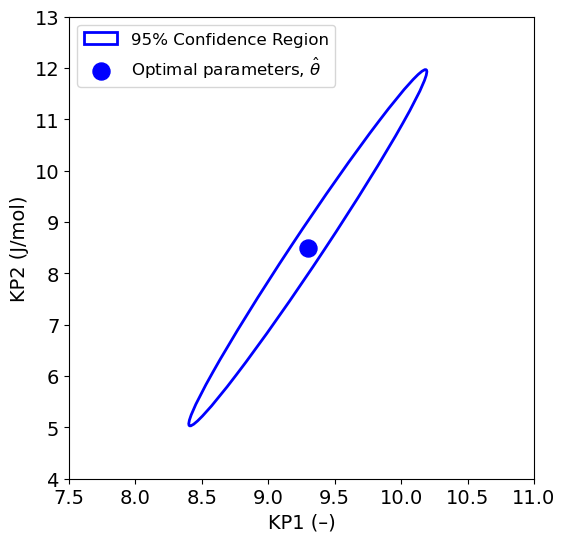

In [44]:
import scipy.stats as stat
from matplotlib.patches import Ellipse

theta_je2 = theta_ordered_m2.to_numpy()  # theta for the joint ellipsoid
CI = 95  # The confidence interval

# Calculate the eigen values and eigen vectors.
eigvals, eigvecs = np.linalg.eigh(cov_seq2)
order = eigvals.argsort()[
    ::-1
]  # returns the descending order index of the eigen values.
eigvals, eigvecs = eigvals[order], eigvecs[:, order]  # reorder

# Define angle and width/height of the ellipse
chi2_val = stat.chi2.ppf(
    CI / 100, df=2
)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor = np.sqrt(chi2_val)
width, height = 2 * scale_factor * np.sqrt(eigvals)  # scaling for 95% Cofidence
angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0]) * 180 / np.pi

# Plot the confidence ellipse
fig, ax = plt.subplots(figsize=(6, 6))

# Create the ellipse object
ellipse = Ellipse(
    xy=theta_je2,
    width=width,
    height=height,
    angle=angle,
    facecolor="none",
    edgecolor="blue",
    lw=2,
    label=f"{CI}% Confidence Region",
)
ax.add_patch(ellipse)

# add labels and formatting
ax.set_xlabel("KP1 (–)", fontsize=14)
ax.set_ylabel("KP2 (J/mol)", fontsize=14)
ax.scatter(
    theta_je2[0],
    theta_je2[1],
    color="blue",
    marker="o",
    s=150,
    label=r"Optimal parameters, $\hat\theta$",
)
# Set proper limits based on ellipse size

# ax.set_xlim(theta_je[0] - width, theta_je[0] + width)
# ax.set_ylim(theta_je[1] - 2 * height, theta_je[1] + 2 * height)


# To plot some random synthetic data points using Monte Carlo sampling for our optimum theta.
# In reality our theta value could be any of these random points.
# n_samples = 100  # number of scatter points we want to plot
# np.random.seed(101)
# theta_samples = np.random.multivariate_normal(theta_je, cov_seq, size=n_samples)
# ax.scatter(
#     theta_samples[:, 0],
#     theta_samples[:, 1],
#     color="blue",
#     alpha=0.1,
#     label="Synthetic samples",
# )
ax.set_xlim(7.5, 11)
ax.set_ylim(4, 13)
ax.legend(fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=14)

## Sequential experiments (2 ramp-F and 1 ramp-FT experiments)
Here, we will use the PFR model to estimate the parameters for sequential experiments using Parmest and then use the DOE to estimate the optimal design.
###  Parameter estimation using Parmest for sequential experiments

In [45]:
exp_num = 3  # number of experiments to combine.
# Choose ``2`` for combining two ramp_F experiments.
# Choose ``3`` for combining all the experiments.
data_m = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
C_BA0_m = {1: 1.56, 2: 1.55, 3: 1.56}
T0_m = {1: 119, 2: 139.4, 3: 139.2}
v0_m = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
alpha_v_m = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
alpha_T_m = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
theta_initial_m = {
    "KP1": 8.01758972730862,
    "KP2": 3.7995866696746776,
}  # theta value from ramp_F2 (using ``theta_ordered.to_dict()``). The parameter estimation is very senitive to this value.
exp_list_pfr = []
for i in range(1, exp_num + 1):
    exp_list_pfr.append(
        TransientPFR(
            data=data_m[i],
            C_BA0=C_BA0_m[i],
            v0=v0_m[i],
            T0=T0_m[i],
            alpha_v=alpha_v_m[i],
            alpha_T=alpha_T_m[i],
            theta_initial=theta_initial_m,
            discr_method="dae.collocation",
            scheme="LAGRANGE-RADAU",
            nfe_t=40,
            nfe_z=20,
            ncp=2,
            t_skip=0,
        )
    )
# BA_exp = TransientPFR(data=data, C_BA0=1.55, v0=9.13, T0=139.4, alpha_v=0.043)
pest_m3 = parmest.Estimator(
    exp_list_pfr,
    obj_function="SSE",
    tee=False,
    solver_options={"linear_solver": "ma57", "max_iter": 200},
)
obj_m3, theta_m3 = pest_m3.theta_est()

# printing model parameters
print("Model Parameters")
theta_ordered_m3 = theta_m3.loc[["KP1", "KP2"]]
print("theta values: ")
print(theta_ordered_m3)
print("\nSSE value: ", obj_m3)

Model Parameters
theta values: 
KP1    9.077090
KP2    7.606165
dtype: float64

SSE value:  0.6888256969662528


###  FIM computation using DOE for 3 sequential experiments

In [46]:
nseq_exp = 3  # choose a experiment number between 1 to 3
theta_doe = theta_ordered_m3.to_dict()  # dict of theta values for the seq experiments
# # solver options
solver = pyo.SolverFactory("ipopt")
solver.options["linear_solver"] = "ma57"
solver.options["max_iter"] = 200
solver.options["tol"] = 1e-5
pr_FIM = None  # prior FIM for sequential experiments
for j in range(1, nseq_exp + 1):
    exp_seq = TransientPFR(
        data=data_i[j],
        C_BA0=C_BA0_i[j],
        v0=v0_i[j],
        T0=T0_i[j],
        alpha_v=alpha_v_i[j],
        alpha_T=alpha_T_i[j],
        theta_initial=theta_doe,
        discr_method="dae.collocation",
        scheme="LAGRANGE-RADAU",
        nfe_t=40,
        nfe_z=20,
        ncp=3,
    )

    doe_seq = DesignOfExperiments(
        exp_seq,
        objective_option="determinant",
        scale_nominal_param_value=False,
        tee=False,
        solver=solver,
        prior_FIM=pr_FIM,
    )
    pr_FIM = np.array(doe_seq.compute_FIM())


print(f"FIM of the {nseq_exp} sequential experiments using PFR Model:")
print(pr_FIM)

det_seq_FIM3 = np.linalg.det(pr_FIM)
print(f"\nDeterminant of the FIM: {det_seq_FIM3}")

print("\nCovariance of the parameters using PFR Model:")
cov_seq3 = np.linalg.inv(pr_FIM)
print(cov_seq3)

FIM of the 3 sequential experiments using PFR Model:
[[391.69061719 -92.4632481 ]
 [-92.4632481   23.38965348]]

Determinant of the FIM: 612.0555580873119

Covariance of the parameters using PFR Model:
[[0.03821492 0.15107002]
 [0.15107002 0.63995925]]


### Joint parameter confidence region (Confidence ellipsoid) - all experiments

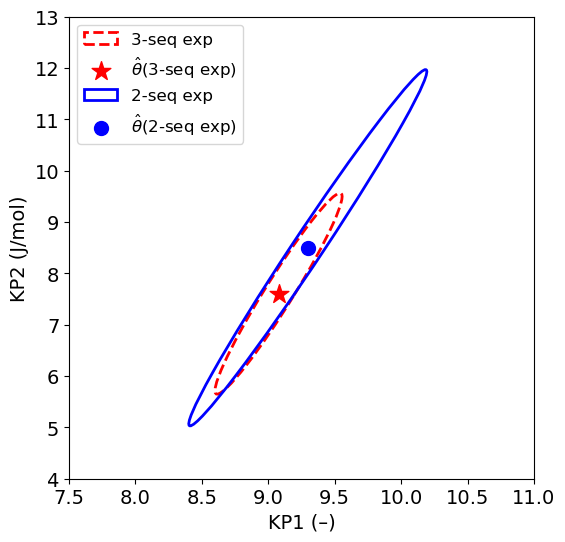

In [47]:
# Joint  Confidence ellipsoid for 3 sequential experiments
theta_je3 = theta_ordered_m3.to_numpy()  # theta for the joint ellipsoid
CI = 95  # The confidence interval

# Calculate the eigen values and eigen vectors.
eigvals3, eigvecs3 = np.linalg.eigh(cov_seq3)

order3 = eigvals3.argsort()[::-1]  # returns the descending order index of the eigen values.
eigvals3, eigvecs3 = eigvals3[order], eigvecs3[:, order3]  # reorder

# Define angle and width/height of the ellipse
chi2_val3 = stat.chi2.ppf(
    CI / 100, df=2
)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor3 = np.sqrt(chi2_val3)
width3, height3 = 2 * scale_factor3 * np.sqrt(eigvals3)  # scaling for 95% Cofidence
angle3 = np.arctan2(eigvecs3[1, 0], eigvecs3[0, 0]) * 180 / np.pi

# Plot the confidence ellipse
fig, ax = plt.subplots(figsize=(6, 6))

# Create the ellipse object
ellipse3 = Ellipse(
    xy=theta_je3,
    width=width3,
    height=height3,
    angle=angle3,
    facecolor="none",
    edgecolor="red",
    ls="--",
    lw=2,
    label="3-seq exp",
)

ax.add_patch(ellipse3)

# add labels and formatting
ax.set_xlabel("KP1 (–)", fontsize=14)
ax.set_ylabel("KP2 (J/mol)", fontsize=14)
ax.scatter(
    theta_je3[0],
    theta_je3[1],
    color="red",
    marker="*",
    s=200,
    label=r"$\hat\theta$(3-seq exp)",
)

# ========================================================
# Joint  Confidence ellipsoid for 2 sequential experiments
theta_je2 = theta_ordered_m2.to_numpy()  # theta for the joint ellipsoid

# Calculate the eigen values and eigen vectors.
eigvals2, eigvecs2 = np.linalg.eigh(cov_seq2)
order2 = eigvals.argsort()[
    ::-1
]  # returns the descending order index of the eigen values.
eigvals2, eigvecs2 = eigvals2[order2], eigvecs2[:, order2]  # reorder

# Define angle and width/height of the ellipse
chi2_val2 = stat.chi2.ppf(
    CI / 100, df=2
)  # Chi-square value for %CI, df -> 2 degrees of freedom (two parameters)
scale_factor2 = np.sqrt(chi2_val2)
width2, height2 = 2 * scale_factor2 * np.sqrt(eigvals2)  # scaling for 95% Cofidence
angle2 = np.arctan2(eigvecs2[1, 0], eigvecs2[0, 0]) * 180 / np.pi

# Plot the confidence ellipse
# Create the ellipse object
ellipse2 = Ellipse(
    xy=theta_je2,
    width=width2,
    height=height2,
    angle=angle2,
    facecolor="none",
    edgecolor="blue",
    lw=2,
    label="2-seq exp",
)

ax.add_patch(ellipse2)

# add labels and formatting
ax.scatter(
    theta_je2[0],
    theta_je2[1],
    color="blue",
    marker="o",
    s=100,
    label=r"$\hat\theta$(2-seq exp)",
)
# Set proper limits based on ellipse size

# ax.set_xlim(theta_je[0] - width, theta_je[0] + width)
# ax.set_ylim(theta_je[1] - 2 * height, theta_je[1] + 2 * height)


# To plot some random synthetic data points using Monte Carlo sampling for our optimum theta.
# In reality our theta value could be any of these random points.
# n_samples = 100  # number of scatter points we want to plot
# np.random.seed(101)
# theta_samples = np.random.multivariate_normal(theta_je, cov_seq, size=n_samples)
# ax.scatter(
#     theta_samples[:, 0],
#     theta_samples[:, 1],
#     color="blue",
#     alpha=0.1,
#     label="Synthetic samples",
# )
ax.set_xlim(7.5, 11)
ax.set_ylim(4, 13)
ax.legend(fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=14)
# ax.set_title("Joint confidence ellipsoid for sequential experiments")

## Simulating the with estimated parameters
We will plot the experimental data and the simulated data using the estimated parameters from the sequential experimental design.

In [48]:
def plot_from_seq_exp(
    n_seq_exp,
    discr_method="dae.collocation",
    scheme="LAGRANGE-RADAU",
    nfe_t=50,
    nfe_z=30,
    ncp=2,
    tee=False,
):
    """
    Plots the experimental and simulated data using the estimated parameters from the sequential experiment.
    Args:
        n_seq_exp (int): Number of sequential experiments.
            n_seq_exp = 1 -> parameter value from only ramp_F1 data,
            n_seq_exp = 2 -> parameter value from ramp_F1 & ramp_F2 data,
            n_seq_exp = 3 -> parameter value from ramp_F1 & ramp_F2 & ramp_FT data
        discr_method (str, optional): Discretization method. Default: "dae.collocation".
        scheme (str, optional): Collocation scheme. Default: "LAGRANGE-RADAU".
        nfe_t (int, optional): Number of finite elements for time. Default: 50.
        nfe_z (int, optional): Number of finite elements for space. Default: 30.
        ncp (int, optional): Number of collocation points. Default: 2.
        tee (bool, optional): Whether to print the solver output. Default: False.
    """

    # This is the final parameters from the sequential experiments
    theta_seq = {
        1: theta_ordered.to_dict(),  # from only ramp_F1
        2: theta_ordered_m2.to_dict(),  # from ramp_F1 & ramp_F2
        3: theta_ordered_m3.to_dict(),  # from ramp_F1 & ramp_F2 & ramp_FT
    }
    # Standard deviations for error bars
    BA_MEAS_ERR = 0.03
    EB_MEAS_ERR = 0.0165

    exp_name = data_i = {1: "ramp_F1", 2: "ramp_F2", 3: "ramp_FT"}
    data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
    C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}
    T0_i = {1: 119, 2: 139.4, 3: 139.2}
    v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
    alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
    alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
    # Let's combine all the estimated theta values and their SSE values in a dictionary for each experiment

    # FOR NFE_T = 20 and NFE_Z = 20, we can simulate the model using the following code:
    # Creating the blank plot
    fig, ax = plt.subplots(figsize=(10, 6))
    # Adding parameter values and SSE value in the plot
    annotation_text = f'  nseq_exp = {n_seq_exp} \n"KP1" = {theta_seq[n_seq_exp]["KP1"]:0.6f} \n"KP2" = {theta_seq[n_seq_exp]["KP2"]:0.6f}'
    ax.annotate(
        annotation_text,
        xy=(0.05, 0.40),  # Position inside the axes
        xycoords="axes fraction",  # Use axes fraction for xy
        xytext=(1.05, 0.2),  # Position outside the axes
        textcoords="axes fraction",  # Use axes fraction for xytext
        fontsize=12,
        color="red",
        verticalalignment="top",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )

    # Selecting color
    colors = {1: "red", 2: "blue", 3: "green"}
    for ind in range(1, 4):
        BA_exp_sim = SimulateTransientPFR(
            data=data_i[ind],
            C_BA0=C_BA0_i[ind],
            v0=v0_i[ind],
            T0=T0_i[ind],
            alpha_v=alpha_v_i[ind],
            alpha_T=alpha_T_i[ind],
            theta=theta_seq[n_seq_exp],
            discr_method=discr_method,
            scheme=scheme,
            nfe_t=nfe_t,
            nfe_z=nfe_z,
            ncp=ncp,
        )
        model_sim = BA_exp_sim.get_labeled_model()
        # ``get_labeled_model()`` takes the instance and build a model for the  instance
        solved_model = BA_exp_sim.simulate(tee=tee)  # we can now simulate the model

        # Extracting time points
        t_con = BA_exp_sim.t_control
        t_sim = (
            t_con * 60
        )  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model

        # Extract C_BA values from solved model
        CBA_sim = np.array([solved_model.C_BA[t, 20].value for t in t_con])

        # Concentration of EB
        CEB_sim = np.array([solved_model.C_EB[t, 20].value for t in t_con])

        # Plotting C_BA values
        ax.errorbar(
            t_sim,
            data_i[ind]["C_BA(M)"],
            yerr=BA_MEAS_ERR,
            fmt="o",
            color=colors[ind],
            capsize=3,
            barsabove=True,
            markersize=5,
            label=f"Experimental - BA: ({exp_name[ind]})",
        )
        ax.plot(
            t_sim,
            CBA_sim,
            color=colors[ind],
            label=f"Simulated - BA: ({exp_name[ind]})",
        )

        # Plotting C_EB values
        ax.errorbar(
            t_sim,
            data_i[ind]["C_EB(M)"],
            yerr=EB_MEAS_ERR,
            fmt="x",
            color=colors[ind],
            capsize=3,
            barsabove=True,
            markersize=5,
            label=f"Experimental - EB: ({exp_name[ind]})",
        )
        ax.plot(
            t_sim,
            CEB_sim,
            ls="--",
            color=colors[ind],
            label=f"Simulated - EB: ({exp_name[ind]})",
        )

        ax.set_xlabel("Time (s)", fontsize=14)
        ax.set_ylabel("C_BA (M)", fontsize=14)
        ax.set_title(f"num of sequential Experiment: {n_seq_exp}", fontsize=16)
        # ax.grid()
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left", fontsize=12)
        ax.tick_params(axis="both", which="major", labelsize=14)

    plt.show()

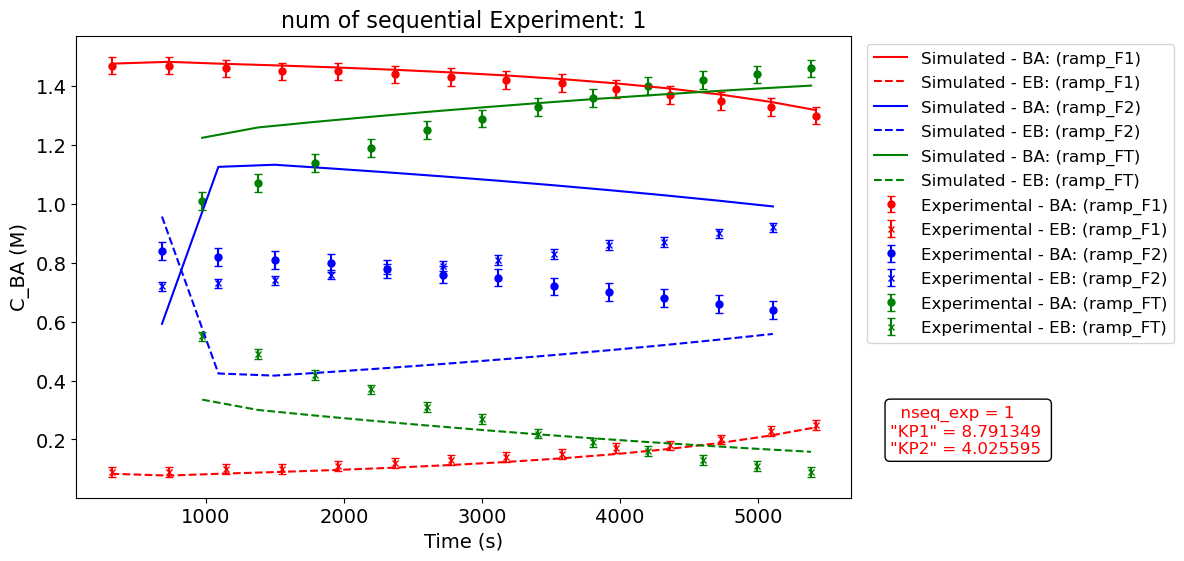

In [49]:
plot_from_seq_exp(n_seq_exp=1)

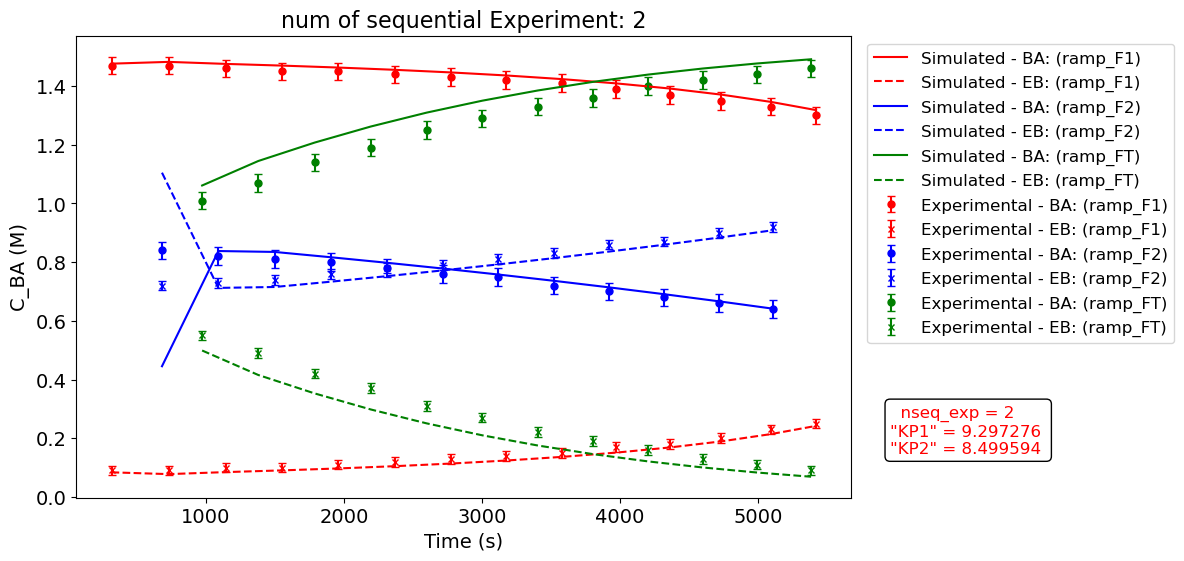

In [50]:
plot_from_seq_exp(n_seq_exp=2)

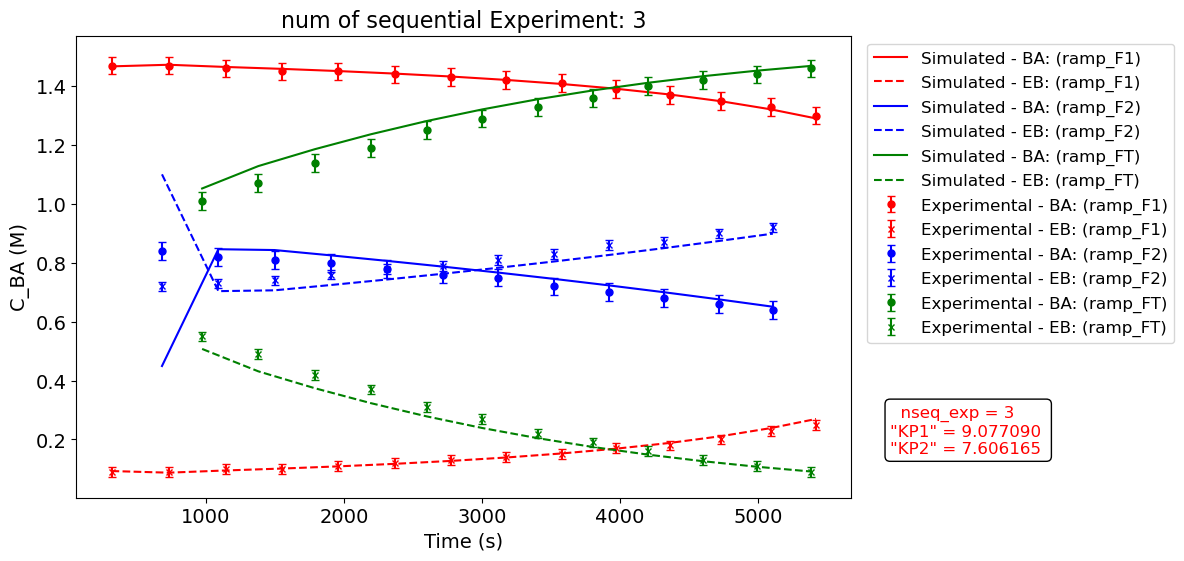

In [51]:
plot_from_seq_exp(n_seq_exp=3)

Define a function to plot all the experimental data points and the best fit from different sequential experiments

In [52]:
def plot_all_seq_exp(
    discr_method="dae.collocation",
    scheme="LAGRANGE-RADAU",
    nfe_t=50,
    nfe_z=30,
    ncp=2,
    tee=False,
):
    """
        scheme (str, optional): Collocation scheme. Default: "LAGRANGE-RADAU".
        nfe_t (int, optional): Number of finite elements for time. Default: 50.
        nfe_z (int, optional): Number of finite elements for space. Default: 30.
        ncp (int, optional): Number of collocation points. Default: 2.
        tee (bool, optional): Whether to print the solver output. Default: False.
    """

    # This is the final parameters from the sequential experiments
    theta_seq = {
        1: theta_ordered.to_dict(),  # from only ramp_F1
        2: theta_ordered_m2.to_dict(),  # from ramp_F1 & ramp_F2
        3: theta_ordered_m3.to_dict(),  # from ramp_F1 & ramp_F2 & ramp_FT
    }

    exp_name = data_i = {1: "ramp_F1", 2: "ramp_F2", 3: "ramp_FT"}
    data_i = {1: ramp_F1, 2: ramp_F2, 3: ramp_FT}
    C_BA0_i = {1: 1.56, 2: 1.55, 3: 1.56}
    T0_i = {1: 119, 2: 139.4, 3: 139.2}
    v0_i = {1: 29.8, 2: 9.13, 3: 10.1}  # feed volumetric flow rate, µL/min
    alpha_v_i = {1: 0.253, 2: 0.043, 3: 0.05}  # flowrate ramp rate, µL/min^2
    alpha_T_i = {1: 0, 2: 0, 3: 0.537}  # temperature ramp rate, °C/min
    # Let's combine all the estimated theta values and their SSE values in a dictionary for each experiment

    # FOR NFE_T = 20 and NFE_Z = 20, we can simulate the model using the following code:
    # Creating the blank plot
    fig, ax = plt.subplots(figsize=(10, 6))
    # Create lists to store handles for legend
    exp_handles = []
    sim_handles = []

    # Selecting color
    colors = {1: "red", 2: "blue", 3: "green"}
    line_styles = {1: "-", 2: (5, (10, 3)), 3: ":"}
    for n_seq_exp in range(1, 4):
        for ind in range(1, 4):
            BA_exp_sim = SimulateTransientPFR(
                data=data_i[ind],
                C_BA0=C_BA0_i[ind],
                v0=v0_i[ind],
                T0=T0_i[ind],
                alpha_v=alpha_v_i[ind],
                alpha_T=alpha_T_i[ind],
                theta=theta_seq[n_seq_exp],
                discr_method=discr_method,
                scheme=scheme,
                nfe_t=nfe_t,
                nfe_z=nfe_z,
                ncp=ncp,
            )
            model_sim = BA_exp_sim.get_labeled_model()
            # ``get_labeled_model()`` takes the instance and build a model for the  instance
            solved_model = BA_exp_sim.simulate(tee=tee)  # we can now simulate the model

            # Extracting time points
            t_con = BA_exp_sim.t_control
            t_sim = (
                t_con * 60
            )  # min to sec, add 110 to start at t = 110 which I considered to be 0 in the model

            # Extract C_BA values from solved model
            CBA_sim = np.array([solved_model.C_BA[t, 20].value for t in t_con])

            # Plotting the experimental data
            if n_seq_exp == 1:                
                exp_plot =ax.scatter(
                    t_sim,
                    data_i[ind]["C_BA(M)"],
                    marker="o",
                    color=colors[ind],
                    label=f"Experimental - Data: ({exp_name[ind]})",
                )
                exp_handles.append(exp_plot)

            # Plotting the simulated data
            sim_plot, = ax.plot(
                t_sim,
                CBA_sim,
                color=colors[ind],
                label=f"Simulated-nseq({n_seq_exp}): ({exp_name[ind]})",
                linestyle=line_styles[n_seq_exp],
            )
            sim_handles.append(sim_plot)

    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_ylabel("C_BA (M)", fontsize=14)
    ax.set_title("Comparison of C_BA values for PFR", fontsize=16)
    ax.grid()
    ax.tick_params(axis="both", which="major", labelsize=14)

    # Now create a combined list: experimental handles first, then simulated handles
    all_handles = exp_handles + sim_handles
    all_labels = [h.get_label() for h in all_handles]        
    ax.legend(
        all_handles,
        all_labels,
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        fontsize=12,
    )

    plt.show()

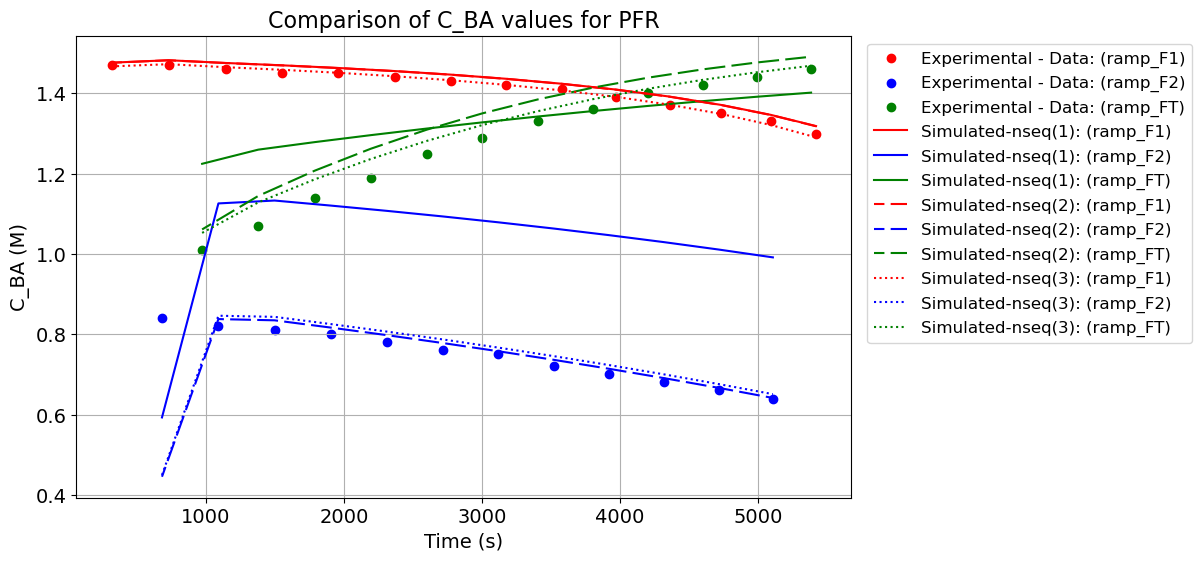

In [53]:
plot_all_seq_exp()

## students's t-test

In [54]:
from scipy.stats import t

# Confidence level
CI = 0.95

# alpha value
alpha = 1 - CI

# extract the variance from the covariance matrix
var_KP1, var_KP2 =np.diag(cov_seq3)

# degrees of freedom (total # of measurements - # of parameters)
dof = len(ramp_F1) + len(ramp_F2) + len(ramp_FT) - 2

# calcuate the t-value
t_value = t.ppf(1-alpha/2, dof)

# margin of error
KP1_margin = t_value * np.sqrt(var_KP1)
KP2_margin = t_value * np.sqrt(var_KP2)

print("KP1 margin of error: %0.2f" % KP1_margin)
print("KP2 margin of error: %0.2f" % KP2_margin)

KP1 margin of error: 0.40
KP2 margin of error: 1.62


## Value of $k_0$ and $E_A$

In [55]:
KP1 = theta_ordered_m3["KP1"]
KP2 = theta_ordered_m3["KP2"]
R = 8.314462618  # Universal gas constant, J/(mol-K)
TM = 378.15  # average temperature of the reactor, K

k_0 = np.exp(-KP1 + (KP2 * 1e4) / (R * TM))  # sec^-1
E_A = KP2 * 1e4  # J/mol

print(f"k_0 =  {k_0: 0.2e} sec^-1")

print(f"E_A = {E_A: 0.2e} J/mol")

k_0 =   3.67e+06 sec^-1
E_A =  7.61e+04 J/mol
